# Capstone Project: Predicting wave height

This Capstone project will be building a model to predict wave height using data about the weather and sea conditions. Using data obtained from the National Data Buoy Centre (NDBC), specifically using buoy 42020, which is located off the coast of Corous Christi, Texas. The data includes the wave height, wind speed, wind direction, sea temperature amongst others. By identifying correlations between these various features, a model can be built to predict the wave height.

This notebook is broken down into 9 sections defined here:
<a id = '1'></a>
* Section 1: Importing data
* [Section 2: Data cleaning & exploration](#2)
* [Section 3: Linear Regression model](#3)
* [Section 4: ARIMA model](#4)
* [Section 5: Improving the models: Linear Regression](#5)
* [Section 6: Improving the models: ARIMA](#6)
* [Section 7: Ensemble methods](#7)
* [Section 8: Neural network model](#8)
* [Section 9: Testing the models](#9)

## 1. Importing data
#### 1.1 Importing libraries

In [1]:
## Essentials
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Linear regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

import statsmodels.api as sm
import statsmodels.tools 

## ARIMA
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

## K-fold Cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

## Time series Cross validation
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

## RandomSearch
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Ridge

## Neural network
from tensorflow import keras
from tensorflow.keras import layers

## Datetime and regex
import datetime
import re

#### 1.2. Importing data
* This data has been taken from the following website: https://www.ndbc.noaa.gov/station_page.php?station=42020


In [2]:
# Imports the data into a dataframe
wave_height_df = pd.read_csv('wave_height_data.txt',sep = 'r\s+',header = 1)

/opt/anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [3]:
# First look at the data
wave_height_df.head(10)

#y  mo dy h  \
0  2011 12 31 23 50  73  1.4  1.8  0.44  5.56  4....      NaN   
1  2012 01 01 00 50  87  2.5  3.1  0.40  5.26  4....      NaN   
2  2012 01 01 01 50 115  3.6  4.0  0.39  5.56  4....      NaN   
3  2012 01 01 02 50 117  3.8  4.5  0.34  5.26  4....      NaN   
4  2012 01 01 03 50 129  4.5  5.2  0.35  5.00  4....      NaN   
5  2012 01 01 04 50 137  4.4  5.2  0.36  5.26  4....      NaN   
6  2012 01 01 05 50 173  4.7  5.5  0.34  5.26  4....      NaN   
7  2012 01 01 06 50 183  4.8  5.6  0.33  5.00  4....      NaN   
8  2012 01 01 07 50 188  4.9  5.7  0.36  5.00  4....      NaN   
9  2012 01 01 08 50 191  4.5  5.1  0.32  5.00  4....      NaN   

   mn degT m/s  m/s     m   sec   sec degT   hPa  degC  degC  degC   mi    ft  
0                                                NaN                           
1                                                NaN                           
2                                                NaN                           
3                                                NaN                           
4                                                NaN                           
5                                                NaN                           
6                                                NaN                           
7                                                NaN                           
8                                                NaN                           
9                                                NaN

* Since all the data has been loaded into one column, the data needs to be extracted and placed within its individual columns 

In [4]:
# Data of the first row
wave_height_df['#y'].loc[0]

'2011 12 31 23 50  73  1.4  1.8  0.44  5.56  4.87 227 1021.7  17.1  20.3 999.0 99.0 99.00'

In [5]:
# Correcting the column names
wave_height_df.rename(columns = {'#y':'col_data'},inplace = True)

In [6]:
# Adding in the column names
column_names = ['#YY', 'MM', 'DD', 'hh', 'mm', 'WDIR', 'WSPD',
                'GST',  'WVHT',  'DPD',   'APD', 'MWD',   'PRES',
                'ATMP',  'WTMP',  'DEWP',  'VIS',  'TIDE']

* Since the data is in the form of a single string, they need to be split into a list of individual strings for manipulation

In [7]:
wave_height_df['col_data'] = wave_height_df['col_data'].str.split(' ')

In [8]:
# Looking at a single index of the dataframe
wave_height_df['col_data'].iloc[0]

['2011',
 '12',
 '31',
 '23',
 '50',
 '',
 '73',
 '',
 '1.4',
 '',
 '1.8',
 '',
 '0.44',
 '',
 '5.56',
 '',
 '4.87',
 '227',
 '1021.7',
 '',
 '17.1',
 '',
 '20.3',
 '999.0',
 '99.0',
 '99.00']

* Since there are uneven spaced in the strings, the lists contain empty strings which need to be removed

In [9]:
# Applies filter that removes None values in the dataframe
wave_height_df['col_data'] = wave_height_df['col_data'].apply(lambda data: list(filter(None, data)))

In [10]:
# Looking at a single index of the dataframe
wave_height_df['col_data'].iloc[0]

['2011',
 '12',
 '31',
 '23',
 '50',
 '73',
 '1.4',
 '1.8',
 '0.44',
 '5.56',
 '4.87',
 '227',
 '1021.7',
 '17.1',
 '20.3',
 '999.0',
 '99.0',
 '99.00']

* Since all the data is stored a list in a single column, the data needs to be separated into their respective columns

In [11]:
# For each name in column_names list, it is added as a column to the dataframe, and then the data 
# is added to the column
for i in range(len(column_names)):
    wave_height_df[column_names[i]] = wave_height_df['col_data'].apply(lambda x: x[i])

* Looking at the data now that the columns have been filled

In [12]:
wave_height_df[column_names].head()

#YY  MM  DD  hh  mm WDIR WSPD  GST  WVHT   DPD   APD  MWD    PRES  ATMP  \
0  2011  12  31  23  50   73  1.4  1.8  0.44  5.56  4.87  227  1021.7  17.1   
1  2012  01  01  00  50   87  2.5  3.1  0.40  5.26  4.69  217  1022.0  18.3   
2  2012  01  01  01  50  115  3.6  4.0  0.39  5.56  4.70  198  1022.2  19.2   
3  2012  01  01  02  50  117  3.8  4.5  0.34  5.26  4.63  215  1022.4  19.8   
4  2012  01  01  03  50  129  4.5  5.2  0.35  5.00  4.66  210  1022.4  20.1   

   WTMP   DEWP   VIS   TIDE  
0  20.3  999.0  99.0  99.00  
1  20.2  999.0  99.0  99.00  
2  20.3  999.0  99.0  99.00  
3  20.3  999.0  99.0  99.00  
4  20.3  999.0  99.0  99.00

* Since the dataframe contains additional columns that are unused, they shall be omitted

In [13]:
wave_height_df = wave_height_df[column_names]

* Successfully imported data frame

In [14]:
wave_height_df.head()

#YY  MM  DD  hh  mm WDIR WSPD  GST  WVHT   DPD   APD  MWD    PRES  ATMP  \
0  2011  12  31  23  50   73  1.4  1.8  0.44  5.56  4.87  227  1021.7  17.1   
1  2012  01  01  00  50   87  2.5  3.1  0.40  5.26  4.69  217  1022.0  18.3   
2  2012  01  01  01  50  115  3.6  4.0  0.39  5.56  4.70  198  1022.2  19.2   
3  2012  01  01  02  50  117  3.8  4.5  0.34  5.26  4.63  215  1022.4  19.8   
4  2012  01  01  03  50  129  4.5  5.2  0.35  5.00  4.66  210  1022.4  20.1   

   WTMP   DEWP   VIS   TIDE  
0  20.3  999.0  99.0  99.00  
1  20.2  999.0  99.0  99.00  
2  20.3  999.0  99.0  99.00  
3  20.3  999.0  99.0  99.00  
4  20.3  999.0  99.0  99.00

#### 1.3. Data dictionary 

The column names and definitions are provided below, obtained from https://www.ndbc.noaa.gov/measdes.shtml

| Column name | Definition |
| --- | --- |
|#YY|Year|
|MM|Month|
|DD|Day|
|hh|Hour|
|mm|Minute|
|WDIR|Wind direction (clockwise from true north)|
|WSPD|Wind speed in m/s|
|GST|Peak 5 sec or 8 sec gust wind speed|
|WVHT|Wave height in m|
|DPD|Dominant wave period (period of the wave with the maximum wave energy)|
|APD|Average wave period|
|MWD|Wave direction of dominant wave period (degrees clockwise from true north)|
|PRES|Sea level pressure in hPA|
|ATMP|Air temperature (Celsius)|
|WTMP|Sea surface temperature (Celsius)|
|DEWP|Dew point temperature (Celsius)|
|VIS|Station visibility (nautical miles)|
|TIDE|Water level in feet above or below Mean lower low water MLLW|

#### 1.4. Test train split

* Executing test train split

In [15]:
wave_height_train, wave_height_test = train_test_split(wave_height_df, test_size = 0.2, random_state = 42)


In [16]:
wave_height_train.head()

#YY  MM  DD  hh  mm WDIR  WSPD   GST  WVHT   DPD   APD  MWD    PRES  \
1317  2012  02  24  23  50    2  13.1  15.9  2.48  6.67  5.40    6  1017.5   
622   2012  01  26  23  50  261   9.8  11.8  1.64  6.67  4.76  160  1010.8   
1419  2012  02  29  05  50  131   7.1   8.1  0.72  4.76  4.06  999  1021.8   
7437  2012  12  11  00  50  308   9.6  10.8  1.33  5.88  4.57  190  1009.6   
7854  2012  12  28  09  50  118   8.8  11.1  0.55  3.45  3.49  999  1015.6   

      ATMP  WTMP   DEWP   VIS   TIDE  
1317  16.2  20.2  999.0  99.0  99.00  
622   19.3  22.1  999.0  99.0  99.00  
1419  21.1  21.7  999.0  99.0  99.00  
7437  21.3  23.0   21.3  99.0  99.00  
7854  16.8  21.9   12.2  99.0  99.00

* Exporting the train and test data to csv files for storage

In [17]:
wave_height_train.to_csv(r'wave_height_train.csv')

wave_height_test.to_csv(r'wave_height_test.csv')

<a id = '2'></a>
## 2. Data cleaning and exploration

=> [Return to the top](#1) <=

Before the data is explored, a back-up copy of the dataset will be made
#### 2.1. Cleaning the data

In [18]:
# Import the training data
wave_height_train = pd.read_csv('wave_height_train.csv')

In [19]:
# Lists the column
list(wave_height_train.columns)

['Unnamed: 0',
 '#YY',
 'MM',
 'DD',
 'hh',
 'mm',
 'WDIR',
 'WSPD',
 'GST',
 'WVHT',
 'DPD',
 'APD',
 'MWD',
 'PRES',
 'ATMP',
 'WTMP',
 'DEWP',
 'VIS',
 'TIDE']

In [20]:
# Quick look at the dataframe
wave_height_train.head()

Unnamed: 0   #YY  MM  DD  hh  mm  WDIR  WSPD   GST  WVHT   DPD   APD  MWD  \
0        1317  2012   2  24  23  50     2  13.1  15.9  2.48  6.67  5.40    6   
1         622  2012   1  26  23  50   261   9.8  11.8  1.64  6.67  4.76  160   
2        1419  2012   2  29   5  50   131   7.1   8.1  0.72  4.76  4.06  999   
3        7437  2012  12  11   0  50   308   9.6  10.8  1.33  5.88  4.57  190   
4        7854  2012  12  28   9  50   118   8.8  11.1  0.55  3.45  3.49  999   

     PRES  ATMP  WTMP   DEWP   VIS  TIDE  
0  1017.5  16.2  20.2  999.0  99.0  99.0  
1  1010.8  19.3  22.1  999.0  99.0  99.0  
2  1021.8  21.1  21.7  999.0  99.0  99.0  
3  1009.6  21.3  23.0   21.3  99.0  99.0  
4  1015.6  16.8  21.9   12.2  99.0  99.0

In [21]:
# Quick look at the dataframe
wave_height_train.tail()

Unnamed: 0   #YY  MM  DD  hh  mm  WDIR  WSPD   GST   WVHT    DPD    APD  \
6347        5226  2012   8  27  10  50    52  11.9  14.1  99.00  99.00  99.00   
6348        5390  2012   9  16  16  50   109   7.8   9.4   0.78   5.88   4.49   
6349         860  2012   2   5  22  50    21   7.4   8.5   1.29   8.33   5.02   
6350        7603  2012  12  17  22  50   260  10.6  13.2   1.45   5.56   4.55   
6351        7270  2012  12   4   1  50   131   8.5  10.0   0.90   4.76   4.11   

      MWD    PRES  ATMP  WTMP   DEWP   VIS  TIDE  
6347  999  1011.5  28.7  29.0  999.0  99.0  99.0  
6348  101  1016.2  26.0  28.5   25.3  99.0  99.0  
6349  163  1018.0  18.7  21.1  999.0  99.0  99.0  
6350  196  1009.0  22.9  23.6   19.3  99.0  99.0  
6351  999  1021.7  23.1  23.5   21.0  99.0  99.0

* Data types

In [22]:
wave_height_train.dtypes

Unnamed: 0      int64
#YY             int64
MM              int64
DD              int64
hh              int64
mm              int64
WDIR            int64
WSPD          float64
GST           float64
WVHT          float64
DPD           float64
APD           float64
MWD             int64
PRES          float64
ATMP          float64
WTMP          float64
DEWP          float64
VIS           float64
TIDE          float64
dtype: object

In [23]:
def clean(df):
    '''
    Function for cleaning the dataframe
    -------
    Argument:
    df - pandas dataframe: dataframe to be cleaned
    -------
    returns:
    clean_df - pandas dataframe: cleaned dataframe
    '''
    # Renames the columns mm to mins (since setting the columns to lower case would mean 2 columns being named mm
    # and unnamed to index
    df_clean = df.rename(columns = {'mm':'mins','Unnamed: 0':'index'})
    
    # Sets all the columns to lower case
    df_clean = df_clean.rename(columns = str.lower)
    
    # Sets the index
    try: 
        df_clean.set_index('index',inplace = True)
    except:
        print('No index column')
        
    # Changes objects to floats/ints
    
    for col in list(df_clean.columns):
        if type(df_clean[col].iloc[0]) == str:
            if '.' in df_clean[col].iloc[0]:
                df_clean[col] = df_clean[col].astype(float)
                print('Changed ',col,' to float')
            else:
                df_clean[col] = df_clean[col].astype(int)
                print('Changed ',col,' to int')
        else:
            print('Columns are fixed')
    
    # Adds a date column with the datetime format
    df_clean['date'] = df_clean['#yy'].astype(str) + '-' +df_clean['mm'].astype(str) + '-' + df_clean['dd'].astype(str) + '-' + df_clean['hh'].astype(str)
    df_clean['date'] = pd.to_datetime(df_clean['date'], format='%Y-%m-%d-%H')
    
    # Removes wave heights above 99m, since exploration revealed them to be an error
    df_clean.drop(df_clean[df_clean['wvht'] >= 99].index,inplace = True)
    # Removes dpd above 99
    df_clean.drop(df_clean[df_clean['dpd'] >= 99].index,inplace = True)
    # Removes gst above 99
    df_clean.drop(df_clean[df_clean['gst'] >= 99].index,inplace = True)
    # Replace the mwd outliers with the average since there are a significant number of outliers
    df_clean['mwd'].loc[df_clean['mwd'] >= 999] = df_clean['mwd'].mean()
    
    return df_clean
    

In [24]:
# Applies the clean function to the data
wave_height_train_clean = clean(wave_height_train)

Columns are fixed
Columns are fixed
Columns are fixed
Columns are fixed
Columns are fixed
Columns are fixed
Columns are fixed
Columns are fixed
Columns are fixed
Columns are fixed
Columns are fixed
Columns are fixed
Columns are fixed
Columns are fixed
Columns are fixed
Columns are fixed
Columns are fixed
Columns are fixed


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [25]:
wave_height_train_clean.head()

#yy  mm  dd  hh  mins  wdir  wspd   gst  wvht   dpd   apd         mwd  \
index                                                                           
1317   2012   2  24  23    50     2  13.1  15.9  2.48  6.67  5.40    6.000000   
622    2012   1  26  23    50   261   9.8  11.8  1.64  6.67  4.76  160.000000   
1419   2012   2  29   5    50   131   7.1   8.1  0.72  4.76  4.06  426.263999   
7437   2012  12  11   0    50   308   9.6  10.8  1.33  5.88  4.57  190.000000   
7854   2012  12  28   9    50   118   8.8  11.1  0.55  3.45  3.49  426.263999   

         pres  atmp  wtmp   dewp   vis  tide                date  
index                                                             
1317   1017.5  16.2  20.2  999.0  99.0  99.0 2012-02-24 23:00:00  
622    1010.8  19.3  22.1  999.0  99.0  99.0 2012-01-26 23:00:00  
1419   1021.8  21.1  21.7  999.0  99.0  99.0 2012-02-29 05:00:00  
7437   1009.6  21.3  23.0   21.3  99.0  99.0 2012-12-11 00:00:00  
7854   1015.6  16.8  21.9   12.2  99.0  99.0 2012-12-28 09:00:00

#### 2.2. Initial glance at the Numerical data & Outliers
* Initial glance at the data

Text(0.5, 1.0, 'Plot of day of the month against wave height')

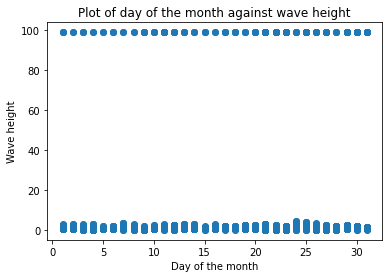

In [26]:
# Scatterplot of day against the wave height 
plt.scatter(wave_height_train[['DD']],wave_height_train[['WVHT']])
    
# Labelling the axes & title
plt.xlabel('Day of the month')
plt.ylabel('Wave height')
plt.title('Plot of day of the month against wave height')

* From the plot above, there are numerous rows where the wave height reaches 99m, this will be assumed as an error in the measurements

In [27]:
# Looking at the dataframe, isolating the outlier wave height
wave_height_train.loc[wave_height_train['WVHT'] >= 99].head(10)

Unnamed: 0   #YY  MM  DD  hh  mm  WDIR  WSPD   GST  WVHT   DPD   APD  \
39         5259  2012   8  31   3  50   208   8.2   9.6  99.0  99.0  99.0   
64         5260  2012   8  31   4  50   172   8.6  10.0  99.0  99.0  99.0   
119        2699  2012   4  22  15  50   352  12.2  15.2  99.0  99.0  99.0   
153        5195  2012   8  22  22  50    96  99.0  99.0  99.0  99.0  99.0   
173        5270  2012   9  11  16  50    96   5.3   6.6  99.0  99.0  99.0   
184        5128  2012   8   9  14  50   208   5.6   6.4  99.0  99.0  99.0   
210        4939  2012   7  25   0  50   261   4.0   4.9  99.0  99.0  99.0   
271        5120  2012   8   7  14  50   295   3.6  99.0  99.0  99.0  99.0   
353        5114  2012   8   5  12  50   108   2.2  99.0  99.0  99.0  99.0   
361        5246  2012   8  30   2  50   163  16.1  20.3  99.0  99.0  99.0   

     MWD    PRES   ATMP   WTMP   DEWP   VIS  TIDE  
39   999  1015.8   25.3   27.5  999.0  99.0  99.0  
64   999  1016.5   27.7   27.5  999.0  99.0  99.0  
119  999  1011.6   18.1   24.0  999.0  99.0  99.0  
153  999  9999.0  999.0  999.0  999.0  99.0  99.0  
173  999  1019.3   27.3   28.3  999.0  99.0  99.0  
184  999  1015.9   29.4   29.9  999.0  99.0  99.0  
210  999  1016.0   28.2   30.7  999.0  99.0  99.0  
271  999  1015.3   28.7  999.0  999.0  99.0  99.0  
353  999  9999.0  999.0  999.0  999.0  99.0  99.0  
361  999  1004.9   29.0   27.6  999.0  99.0  99.0

* Percentage of rows where the wave height is greater than 99

In [28]:
print('Outliers as a percentage of the total:',wave_height_train['WVHT'].
      loc[wave_height_train['WVHT'] >= 99].count()/wave_height_train['WVHT'].count() * 100)

Outliers as a percentage of the total: 2.4086901763224184


* Looking at the correlations between wave height and dominant wave period

Text(0.5, 1.0, 'Plot of dominant wave period against the wave height')

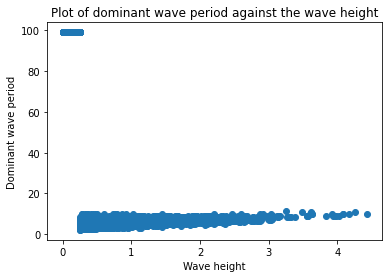

In [29]:
# Plots a new scatterplot excluding the outlier wave heights
plt.scatter(wave_height_train[['WVHT']].loc[wave_height_train['WVHT']<99],wave_height_train[['DPD']].
            loc[wave_height_train['WVHT']<99])

# Setting the axes and title
plt.xlabel('Wave height')
plt.ylabel('Dominant wave period')
plt.title('Plot of dominant wave period against the wave height')

Text(0.5, 1.0, 'Plot of gust speed against wave height,\nomitting the wave height outliers')

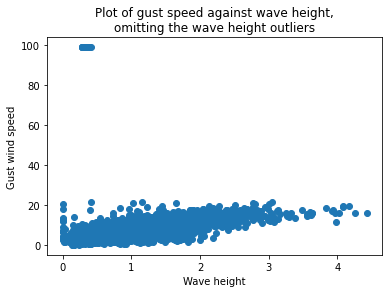

In [30]:
# Plotting a scatter plot of wave height against gust wind speed
plt.scatter(wave_height_train[['WVHT']].loc[wave_height_train['WVHT']<99],wave_height_train[['GST']].loc[wave_height_train['WVHT']<99])

# Setting the axes and title
plt.xlabel('Wave height')
plt.ylabel('Gust wind speed')
plt.title('Plot of gust speed against wave height,\nomitting the wave height outliers')

Text(0.5, 1.0, 'Plot of wave direction against wave height,\nomitting the wave height outliers')

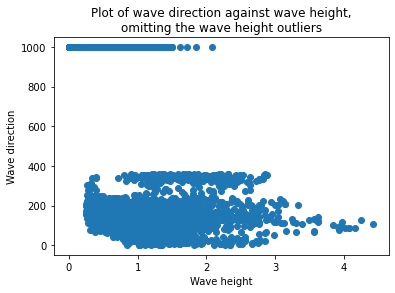

In [31]:
# Plotting a scatter plot of wave height against wave direction
plt.scatter(wave_height_train[['WVHT']].loc[wave_height_train['WVHT']<99],wave_height_train[['MWD']].loc[wave_height_train['WVHT']<99])

# Setting the axes and title
plt.xlabel('Wave height')
plt.ylabel('Wave direction')
plt.title('Plot of wave direction against wave height,\nomitting the wave height outliers')

* From the graphs above, it is also clear that there are prominent outliers in the dominant wave period, gust wind speed, and wave direction as well

In [32]:
wave_height_train[['DPD']].loc[wave_height_train['DPD'] >= 99].head(10)

DPD
5    99.0
19   99.0
39   99.0
64   99.0
78   99.0
80   99.0
119  99.0
153  99.0
173  99.0
184  99.0

* Outliers as a percentage of total for dominant wave period

In [33]:
print('Outliers as a percentage of the total:',wave_height_train[['DPD']].
      loc[wave_height_train['DPD'] >= 99].count()/wave_height_train[['DPD']].count() * 100)


Outliers as a percentage of the total: DPD    6.092569
dtype: float64


* Outliers as a percentage of total for gust wind speed

In [34]:
print('Outliers as a percentage of the total:',wave_height_train['GST'].
      loc[wave_height_train['GST'] >= 99].count()/wave_height_train[['DPD']].count() * 100)


Outliers as a percentage of the total: DPD    0.991814
dtype: float64


In [35]:
print('Outliers as a percentage of the total:',wave_height_train['MWD'].
      loc[wave_height_train['MWD'] >= 999].count()/wave_height_train[['MWD']].count() * 100)


Outliers as a percentage of the total: MWD    36.508186
dtype: float64


* Since the wave direction has a significant number of outliers, they cannot be omitted since too many rows would be lost
* Next, plots exluding the outliers will be made, to have a clear view of the data 

Text(0.5, 1.0, 'Plot of Dominant wave period against wave height')

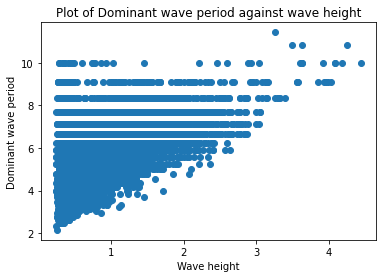

In [36]:
# Defining the conditions to eliminate the outliers
cond_1 = wave_height_train['WVHT'] < 99
cond_2 = wave_height_train['DPD'] < 99

# Plotting a scatter plot with the conditions eliminating the outliers
plt.scatter(wave_height_train[['WVHT']].
            loc[cond_1 & cond_2],wave_height_train[['DPD']].loc[cond_1 & cond_2])

# Setting the axes and title
plt.xlabel('Wave height')
plt.ylabel('Dominant wave period')
plt.title('Plot of Dominant wave period against wave height')


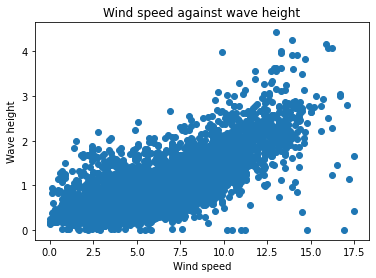

In [37]:
# Defining a new condition to remove the gust wind speed outliers
cond_3 = wave_height_train['GST'] < 99

# Plotting a scatter plot of wind
plt.scatter(wave_height_train[['WSPD']].loc[cond_1 & cond_3],wave_height_train[['WVHT']].
            loc[cond_1 & cond_3])

# Setting the axes and title
plt.xlabel('Wind speed')
plt.ylabel('Wave height')
plt.title('Wind speed against wave height')

# Saving the figure for the presentation
plt.savefig('wind_wave.png')
plt.show()

Text(0.5, 1.0, 'Plotting the wave direction against wave height,\nomitting the outliers ')

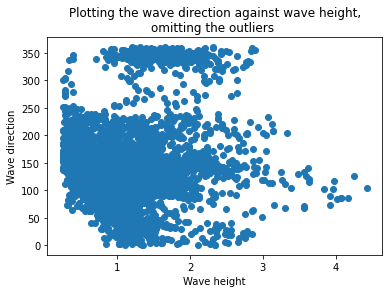

In [38]:
# Defining a new condition to remove the wave direction outliers
cond_4 = wave_height_train['MWD'] < 999

# Plotting a scatter plot of wave height against wave direction, omitting the outliers
plt.scatter(wave_height_train[['WVHT']].loc[cond_1 & cond_4],wave_height_train[['MWD']].
            loc[cond_1 & cond_4])

# Setting the axes and title
plt.xlabel('Wave height')
plt.ylabel('Wave direction')
plt.title('Plotting the wave direction against wave height,\nomitting the outliers ')

#### 2.3. Nulls
* Checking for nulls

In [39]:
def null_vals(dataframe):
    '''
    Function to show both number of nulls and the percentage of nulls in the each column
    ----------
    Parameters:
    dataframe : pandas dataframe
        - Dataframe to count nulls for
    --------
    Returns:
    null_vals.sort_values('percent', ascending=False) : pandas dataframe
        - A dataframe showing the name of each column and its corresponding number and percent
        of null values
    '''
    # Counting the number of nulls in the dataframe
    null_vals = dataframe.isnull().sum()
    
    # Obtains the total number of rows
    total_cnt = len(dataframe)
    
    # Creates a new dataframe with a 'null' column and an index containing the name of each column
    null_vals = pd.DataFrame(null_vals,columns=['null'])
    
    # Adds a percentage column to calculate the number of nulls as a percentage of the entire column
    null_vals['percent'] = round((null_vals['null']/total_cnt)*100,3)
    
    # Arranges the dataframe to put the largest number of nulls at the top
    return null_vals.sort_values('percent', ascending=False)

In [40]:
# Applies the null_vals function to the cleaned data
null_vals(wave_height_train_clean)

null  percent
#yy      0      0.0
apd      0      0.0
tide     0      0.0
vis      0      0.0
dewp     0      0.0
wtmp     0      0.0
atmp     0      0.0
pres     0      0.0
mwd      0      0.0
dpd      0      0.0
mm       0      0.0
wvht     0      0.0
gst      0      0.0
wspd     0      0.0
wdir     0      0.0
mins     0      0.0
hh       0      0.0
dd       0      0.0
date     0      0.0

#### 2.4. Data exploration
* Since there no nulls, the data can now be further explored

In [41]:
wave_height_train_clean.describe()

#yy           mm           dd          hh    mins         wdir  \
count  5947.0  5947.000000  5947.000000  5947.00000  5947.0  5947.000000   
mean   2012.0     6.316462    16.023373    11.62603    50.0   159.711787   
std       0.0     3.613668     8.723504     6.91708     0.0    96.948194   
min    2012.0     1.000000     1.000000     0.00000    50.0     0.000000   
25%    2012.0     3.000000     9.000000     6.00000    50.0    85.000000   
50%    2012.0     6.000000    16.000000    12.00000    50.0   144.000000   
75%    2012.0    10.000000    24.000000    18.00000    50.0   233.000000   
max    2012.0    12.000000    31.000000    23.00000    50.0   359.000000   

              wspd          gst         wvht          dpd          apd  \
count  5947.000000  5947.000000  5947.000000  5947.000000  5947.000000   
mean      6.305414     7.664453     0.958107     5.637520     4.400341   
std       2.971243     3.534003     0.584670     1.465639     0.710569   
min       0.100000     0.400000     0.250000     2.150000     2.610000   
25%       4.100000     5.000000     0.500000     4.550000     3.920000   
50%       6.100000     7.300000     0.820000     5.560000     4.340000   
75%       8.200000     9.800000     1.260000     6.670000     4.860000   
max      17.500000    21.700000     4.430000    11.430000     7.320000   

               mwd         pres         atmp         wtmp         dewp  \
count  5947.000000  5947.000000  5947.000000  5947.000000  5947.000000   
mean    240.777276  1017.056751    22.595258    25.045031   658.437347   
std     140.950090     4.961485    13.372308     3.140824   467.517182   
min       1.000000  1000.300000     5.000000    18.300000    -0.200000   
25%     131.000000  1014.000000    20.100000    22.600000    21.400000   
50%     175.000000  1016.700000    23.000000    24.700000   999.000000   
75%     426.263999  1020.500000    26.000000    27.900000   999.000000   
max     426.263999  1034.700000   999.000000    31.800000   999.000000   

          vis    tide  
count  5947.0  5947.0  
mean     99.0    99.0  
std       0.0     0.0  
min      99.0    99.0  
25%      99.0    99.0  
50%      99.0    99.0  
75%      99.0    99.0  
max      99.0    99.0

* Exploring correlations

In [42]:
wave_height_train_clean.corr()

#yy        mm        dd        hh  mins      wdir      wspd       gst  \
#yy   NaN       NaN       NaN       NaN   NaN       NaN       NaN       NaN   
mm    NaN  1.000000  0.036844  0.004022   NaN -0.069572  0.008444  0.036236   
dd    NaN  0.036844  1.000000  0.002578   NaN  0.043522  0.088764  0.089647   
hh    NaN  0.004022  0.002578  1.000000   NaN  0.012502 -0.044737 -0.039040   
mins  NaN       NaN       NaN       NaN   NaN       NaN       NaN       NaN   
wdir  NaN -0.069572  0.043522  0.012502   NaN  1.000000  0.037692  0.034318   
wspd  NaN  0.008444  0.088764 -0.044737   NaN  0.037692  1.000000  0.989198   
gst   NaN  0.036236  0.089647 -0.039040   NaN  0.034318  0.989198  1.000000   
wvht  NaN -0.089059  0.040265  0.011174   NaN -0.022643  0.747316  0.745763   
dpd   NaN -0.161743  0.005733  0.007272   NaN -0.035161  0.141302  0.129129   
apd   NaN -0.170378 -0.034324 -0.005069   NaN -0.074678  0.213160  0.209621   
mwd   NaN  0.103034  0.006816 -0.022151   NaN  0.199067 -0.057682 -0.041583   
pres  NaN -0.115175 -0.047318 -0.005288   NaN -0.258046 -0.033386 -0.003853   
atmp  NaN  0.058994  0.013844 -0.006421   NaN  0.024681 -0.108229 -0.124716   
wtmp  NaN  0.418919  0.044183  0.024982   NaN  0.038634 -0.278219 -0.285258   
dewp  NaN -0.875028 -0.065977 -0.002968   NaN  0.132946 -0.100409 -0.134745   
vis   NaN       NaN       NaN       NaN   NaN       NaN       NaN       NaN   
tide  NaN       NaN       NaN       NaN   NaN       NaN       NaN       NaN   

          wvht       dpd       apd       mwd      pres      atmp      wtmp  \
#yy        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
mm   -0.089059 -0.161743 -0.170378  0.103034 -0.115175  0.058994  0.418919   
dd    0.040265  0.005733 -0.034324  0.006816 -0.047318  0.013844  0.044183   
hh    0.011174  0.007272 -0.005069 -0.022151 -0.005288 -0.006421  0.024982   
mins       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
wdir -0.022643 -0.035161 -0.074678  0.199067 -0.258046  0.024681  0.038634   
wspd  0.747316  0.141302  0.213160 -0.057682 -0.033386 -0.108229 -0.278219   
gst   0.745763  0.129129  0.209621 -0.041583 -0.003853 -0.124716 -0.285258   
wvht  1.000000  0.488492  0.689383 -0.329120 -0.045142 -0.110469 -0.297931   
dpd   0.488492  1.000000  0.772663 -0.672972 -0.106895 -0.014294 -0.024740   
apd   0.689383  0.772663  1.000000 -0.609488 -0.033258 -0.053336 -0.161128   
mwd  -0.329120 -0.672972 -0.609488  1.000000 -0.028660  0.001854  0.039783   
pres -0.045142 -0.106895 -0.033258 -0.028660  1.000000 -0.172231 -0.450039   
atmp -0.110469 -0.014294 -0.053336  0.001854 -0.172231  1.000000  0.276441   
wtmp -0.297931 -0.024740 -0.161128  0.039783 -0.450039  0.276441  1.000000   
dewp  0.000961  0.198055  0.140146 -0.111531 -0.049415  0.029254 -0.118980   
vis        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
tide       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

          dewp  vis  tide  
#yy        NaN  NaN   NaN  
mm   -0.875028  NaN   NaN  
dd   -0.065977  NaN   NaN  
hh   -0.002968  NaN   NaN  
mins       NaN  NaN   NaN  
wdir  0.132946  NaN   NaN  
wspd -0.100409  NaN   NaN  
gst  -0.134745  NaN   NaN  
wvht  0.000961  NaN   NaN  
dpd   0.198055  NaN   NaN  
apd   0.140146  NaN   NaN  
mwd  -0.111531  NaN   NaN  
pres -0.049415  NaN   NaN  
atmp  0.029254  NaN   NaN  
wtmp -0.118980  NaN   NaN  
dewp  1.000000  NaN   NaN  
vis        NaN  NaN   NaN  
tide       NaN  NaN   NaN

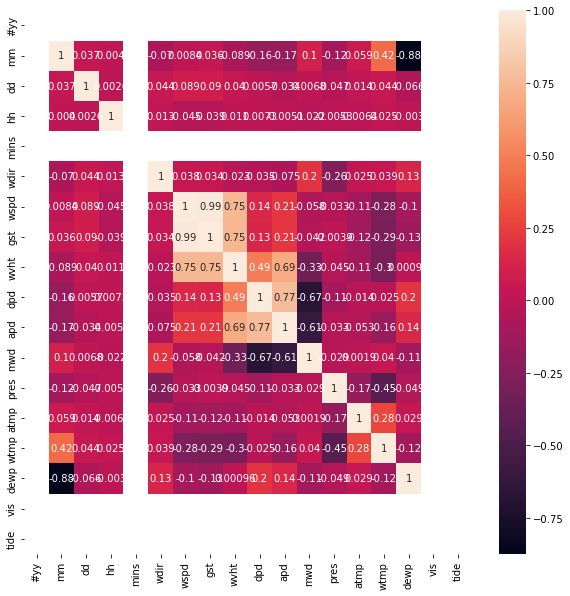

In [43]:
plt.figure(figsize = (10, 10))
sns.heatmap(wave_height_train_clean.corr(), annot = True)

plt.show()

* The heatmap shows that there are many null correlations between various features, so they shall be omitted in further study. Moreover, since apd (average period) is mathematically related to wave height, hence the correlation of 1, it will not be used in the model. 

In [44]:
# Creates a list of column names for making a pairplot
pairplot_cols = list(wave_height_train_clean.columns)
# List of non-numerical lists
nn_cols = ['#yy','mins','vis','tide','apd']

# Removes the non-numerical column names in the pairplot_cols list
for cols in nn_cols:
    pairplot_cols.remove(cols)
    print('Removed '+cols)

Removed #yy
Removed mins
Removed vis
Removed tide
Removed apd


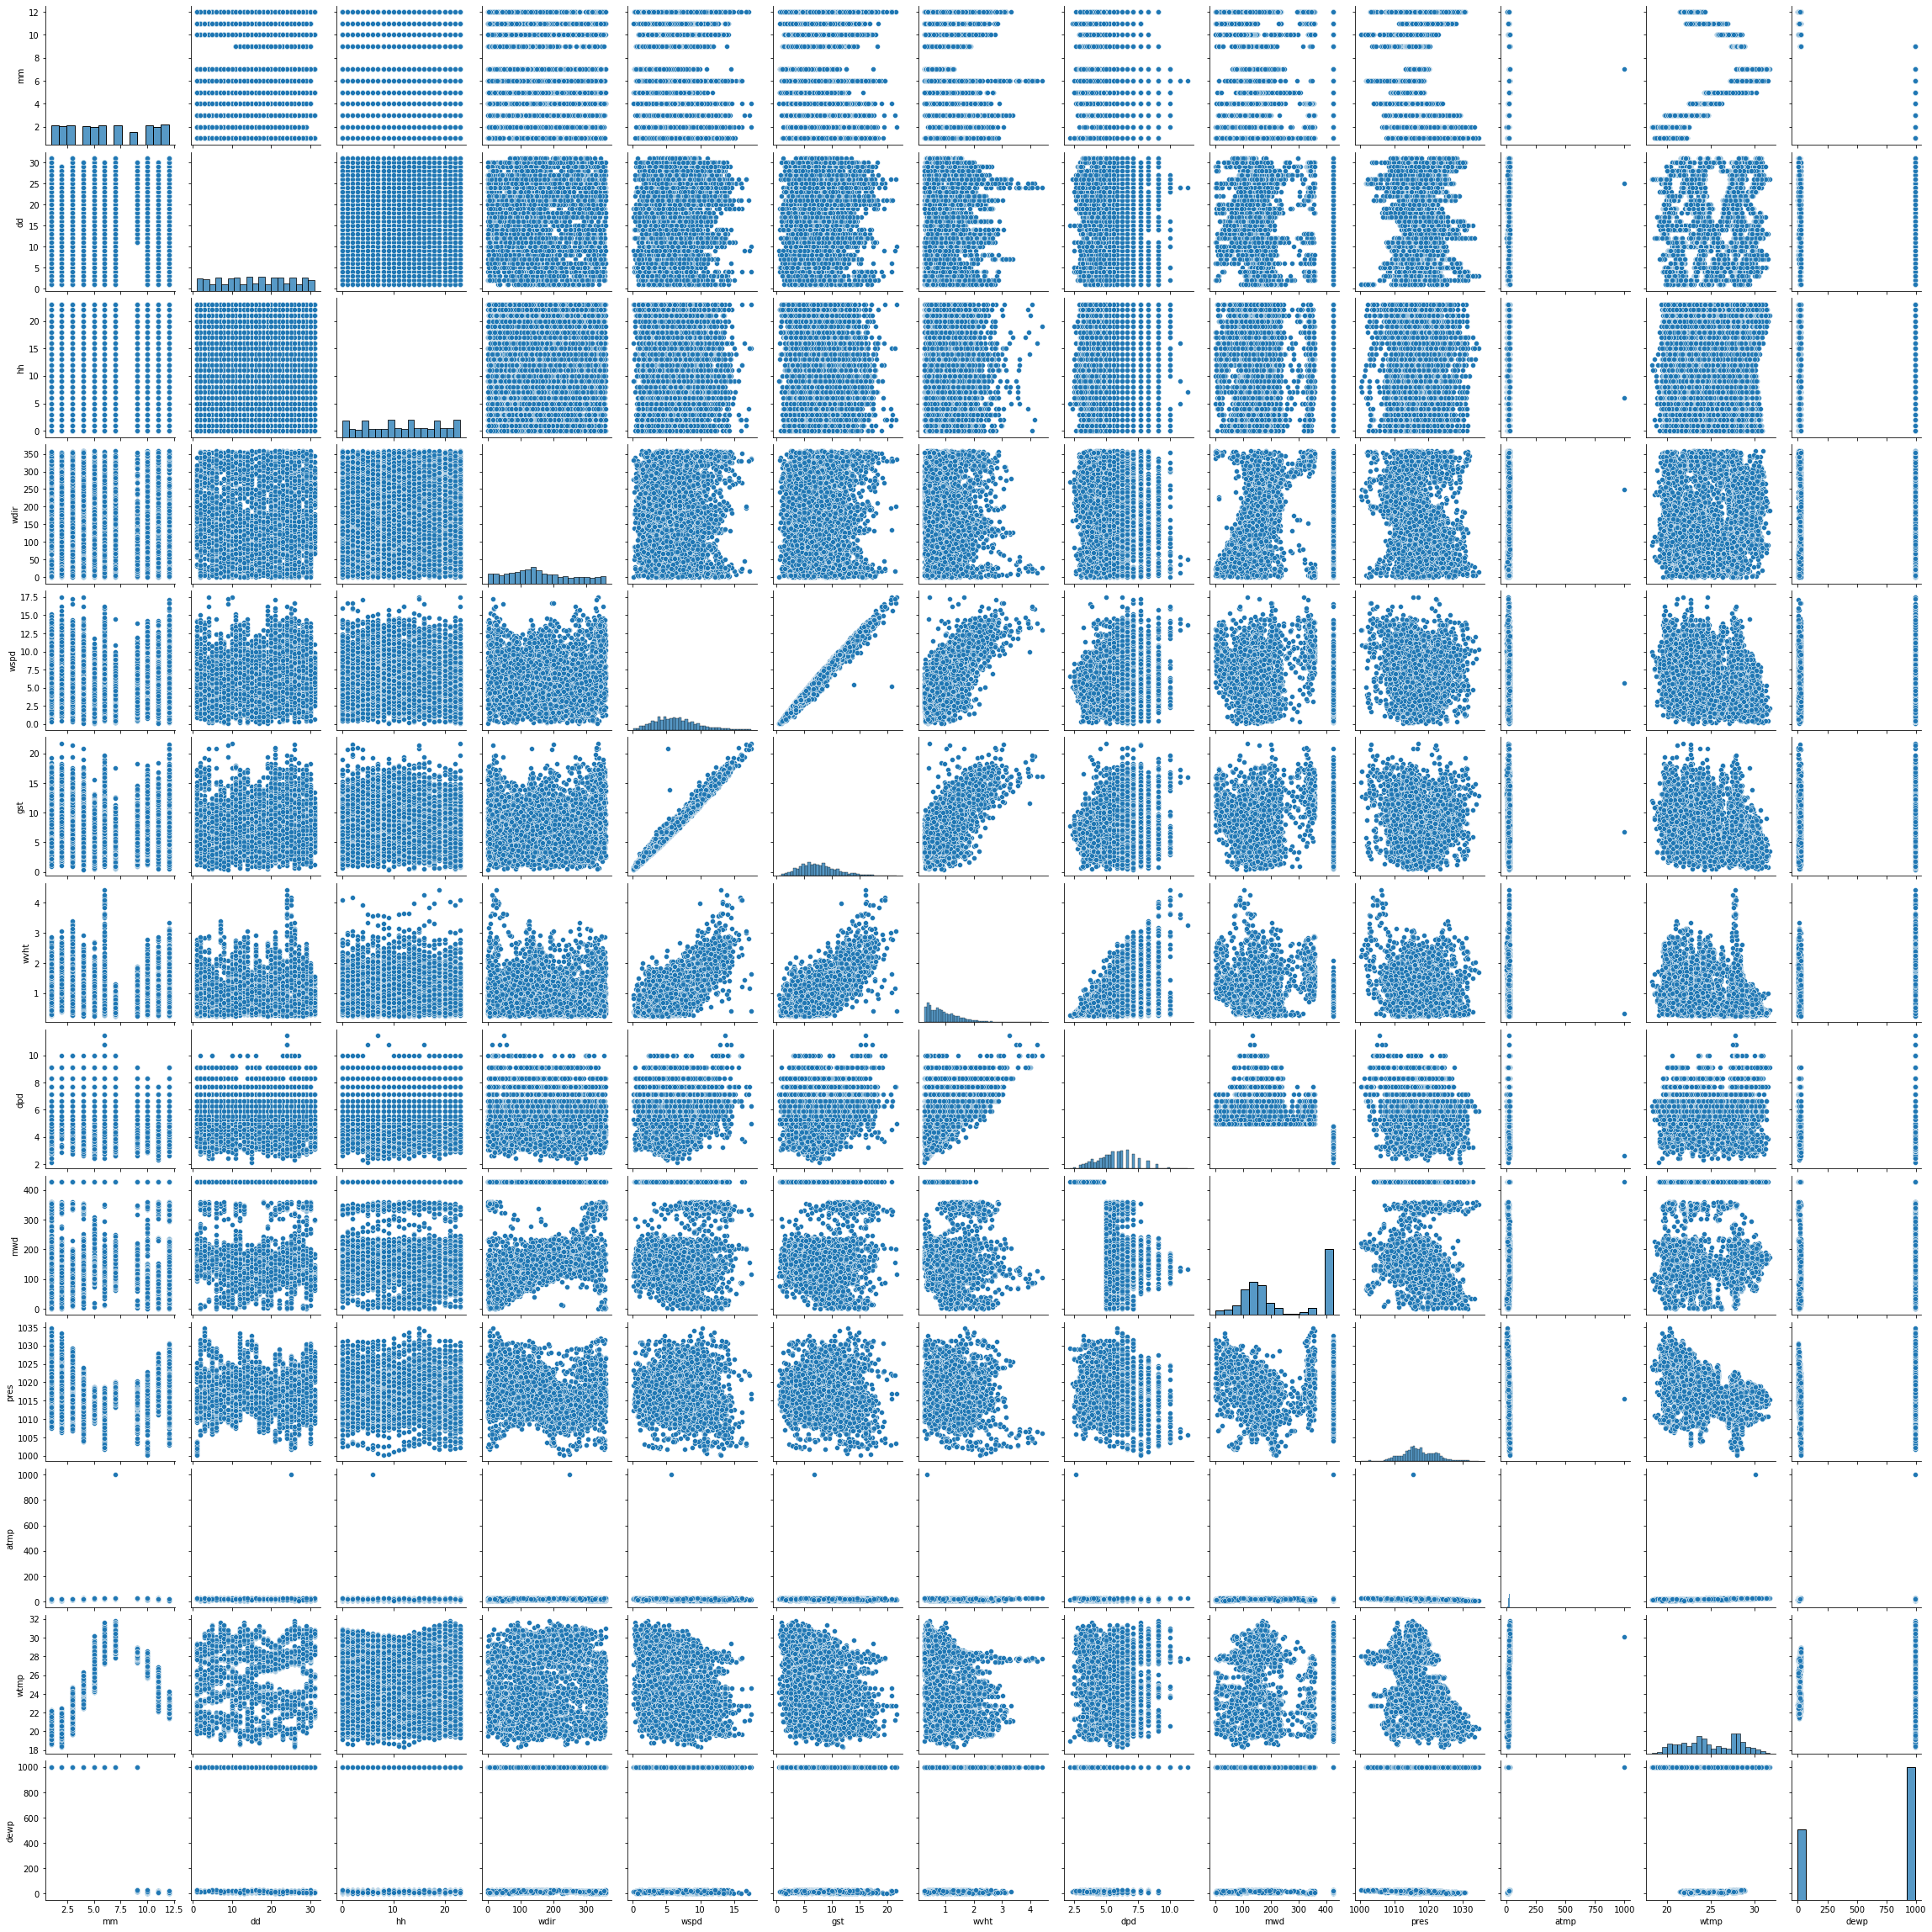

In [45]:
# Creates a pairplot using the pairplot_cols
sns.pairplot(wave_height_train_clean[pairplot_cols])

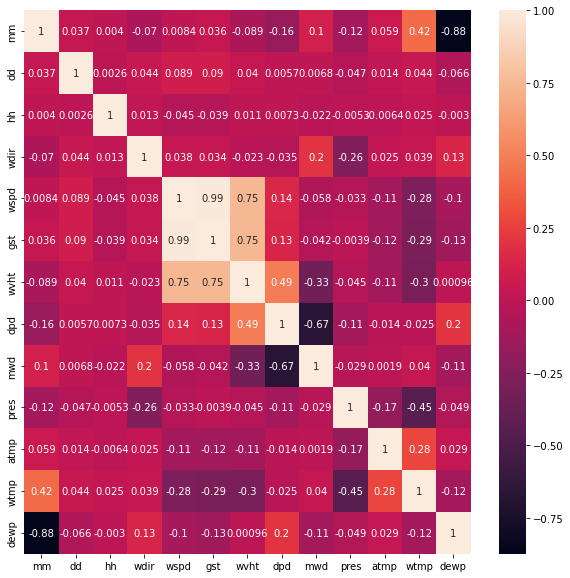

In [46]:
# Creates a heat map of the correlations in the numerical columns
plt.figure(figsize = (10, 10))
sns.heatmap(wave_height_train_clean[pairplot_cols].corr(), annot = True)

plt.show()

* It can be seen that the features with the highest correlations are wspd (wind speed), gst (gust wind speed), dpd (dominant wave period).

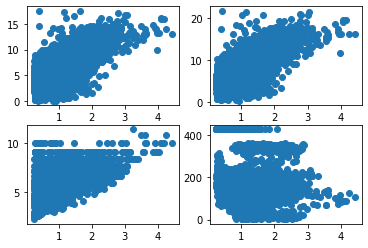

In [47]:
fig, axs = plt.subplots(2,2)

# Creates 4 plots showing the correlation between 'wvht' and the columns listed above
axs[0,0].scatter(wave_height_train_clean[['wvht']],wave_height_train_clean[['wspd']])
axs[0,1].scatter(wave_height_train_clean[['wvht']],wave_height_train_clean[['gst']])
axs[1,0].scatter(wave_height_train_clean[['wvht']],wave_height_train_clean[['dpd']])
axs[1,1].scatter(wave_height_train_clean[['wvht']],wave_height_train_clean[['mwd']])

* Looking at data distribution

<AxesSubplot:ylabel='Count'>

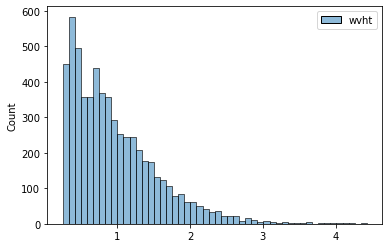

In [48]:
# Histplot of 'wvht'
sns.histplot(wave_height_train_clean[['wvht']])

<AxesSubplot:ylabel='Count'>

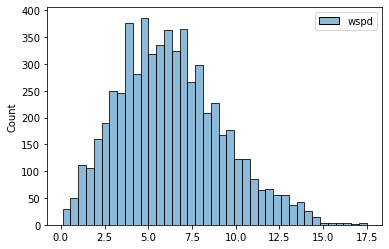

In [49]:
# Histplot of 'wspd'
sns.histplot(wave_height_train_clean[['wspd']])

<AxesSubplot:ylabel='Count'>

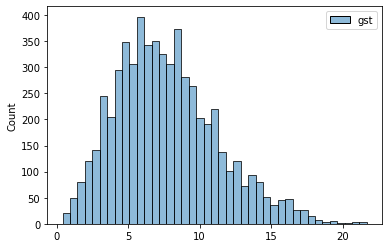

In [50]:
# Histplot of 'gst'
sns.histplot(wave_height_train_clean[['gst']])

<AxesSubplot:ylabel='Count'>

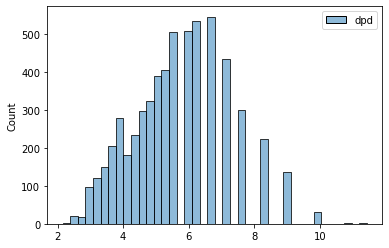

In [51]:
# Histplot of 'dpd'
sns.histplot(wave_height_train_clean[['dpd']])

<AxesSubplot:ylabel='Count'>

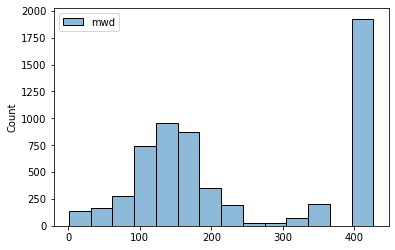

In [52]:
# Histplot of 'mwd'
sns.histplot(wave_height_train_clean[['mwd']])

* Looking at wave height over time

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6402: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  key,


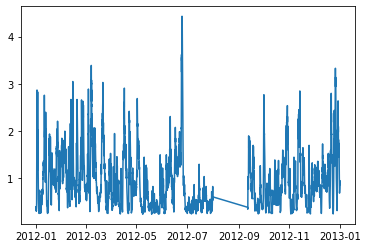

In [53]:
# Creates a dataframe from the wave_height_train_clean with the 'date' and 'wvht' columns
wave_height_time = wave_height_train_clean[['date','wvht']]

# Sets the 'date' column to the index
wave_height_time.set_index('date',inplace = True)

# Sorts the index
wave_height_time.sort_index(inplace = True)

# Plots the 'wvht' against the data
plt.plot(wave_height_time[['wvht']])

## 3. Feature engineering

#### 3.1. Applying empirical equation

From the research, it has been discovered that wave height can be calculated using the empirical formula as follows:

$H_{f} = \frac{\lambda_{5}u^2}{g}$

Where $H_{f}$ is the height of the wave, $\lambda_{5}$ is a constant, approximately equal to 0.27, $u$ is the windspeed, and $g$ is acceleration due to gravity.

This equation can be applied to the dataframe to obtain an approximate value for wave height, that could be used as a feature.

Feature engineering function

In [54]:
def feature_eng(df):
    '''
    Function for feature engineering the dataset
    ---------
    Parameters:
    df - pandas dataframe: input dataframe
    ---------
    Returns:
    df - pandas dataframe: dataframe with feature engineering columns
    '''
    # Applying empirical formula
    # Defining constants
    u = 0.27
    g = 9.81
    
    # Applying the equation to the windspeed and gust windspeed
    df['empirical'] = (df['wspd']**2 * u) / g
    df['empirical_2'] = (df['gst']**2 * u) / g
    
    # Difference between wind direction and wave direction
    df['dir_dif'] = df['wdir'] - df['mwd']
    
    return df

In [55]:
# Applying adding columns for the values of the empirical equation
wave_height_train_clean = feature_eng(wave_height_train_clean)

* Plotting the wave height and the results of the equation for visual comparison

Text(0.5, 1.0, 'Plots of wave height as derived from the equation and the actual wave height')

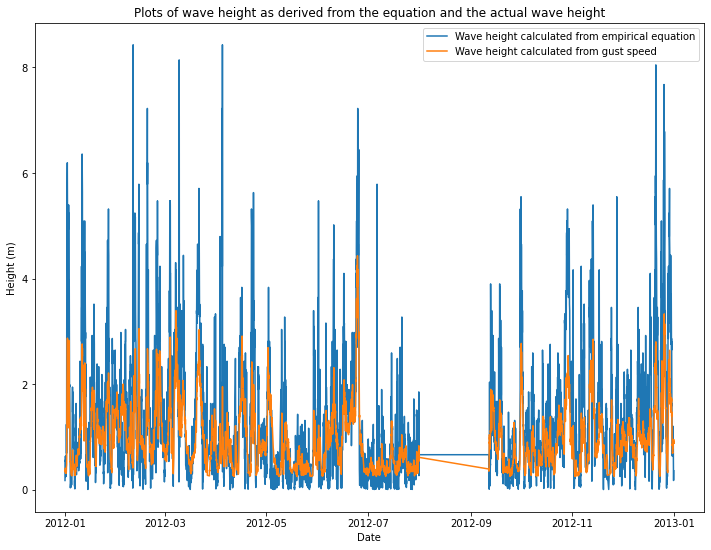

In [56]:
# Creating a new dataframe for plotting the wave height over time
wave_height_time_eq = wave_height_train_clean[['empirical','empirical_2','wvht','date']]

# Sets the index as the date
wave_height_time_eq.set_index('date',inplace = True)

# Sorts the dates in order
wave_height_time_eq.sort_index(inplace = True)

# Plots the result of the empirical formula (calculated from mean wind speed) compared
# to the actual wave height
plt.figure(figsize=(12,9))

plt.plot(wave_height_time_eq['empirical'])
plt.plot(wave_height_time_eq['wvht'])

# Adds the axes, title and legend
plt.legend(['Wave height calculated from empirical equation','Wave height calculated from gust speed','Wave height'])
plt.xlabel('Date')
plt.ylabel('Height (m)')
plt.title('Plots of wave height as derived from the equation and the actual wave height')

Text(0.5, 1.0, 'Plots of wave height as derived from the equation and the actual wave height')

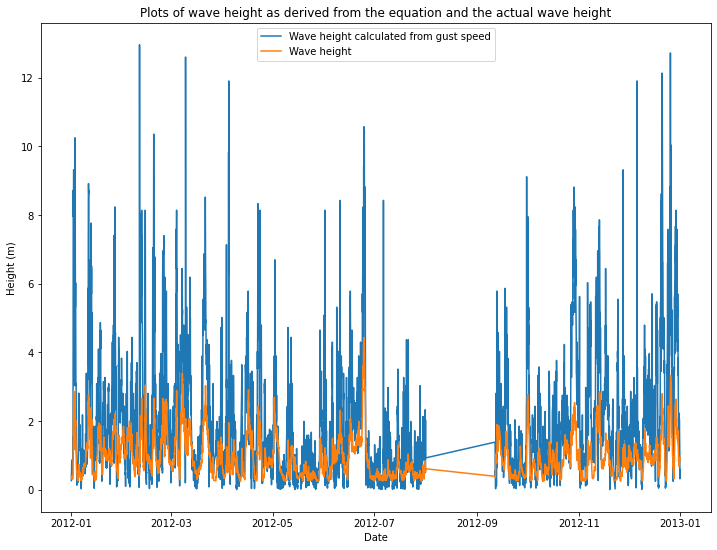

In [57]:
# Plots the result of the empirical formula (calculated from gust wind speed) compared
# to the actual wave height
plt.figure(figsize=(12,9))

plt.plot(wave_height_time_eq['empirical_2'])
plt.plot(wave_height_time_eq['wvht'])

# Adds the axes, title and legend
plt.legend(['Wave height calculated from gust speed','Wave height'])
plt.xlabel('Date')
plt.ylabel('Height (m)')
plt.title('Plots of wave height as derived from the equation and the actual wave height')

Text(0.5, 1.0, 'Plot of wave height against wave height calculated \nfrom mean wind speed')

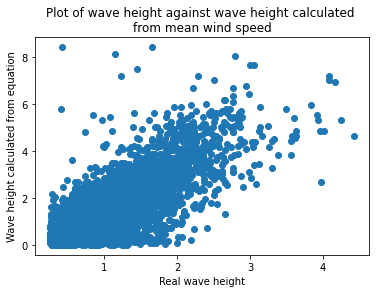

In [58]:
# Scatterplot of wave height and the empirical equation (calculated from the mean wind speed)
plt.scatter(wave_height_train_clean['wvht'],wave_height_train_clean['empirical'])

# Adding axes and title
plt.xlabel('Real wave height')
plt.ylabel('Wave height calculated from equation')
plt.title('Plot of wave height against wave height calculated \nfrom mean wind speed')

Text(0.5, 1.0, 'Plot of wave height against wave height calculated \nfrom gust wind speed')

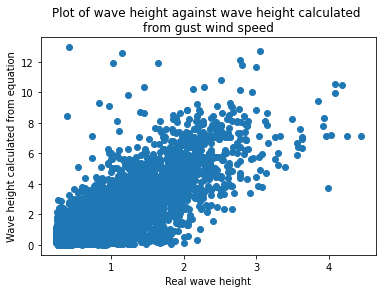

In [59]:
# Scatterplot of wave height and the empirical equation (calculated from the gust wind speed)
plt.scatter(wave_height_train_clean['wvht'],wave_height_train_clean['empirical_2'])

# Adding axes and title
plt.xlabel('Real wave height')
plt.ylabel('Wave height calculated from equation')
plt.title('Plot of wave height against wave height calculated \nfrom gust wind speed')

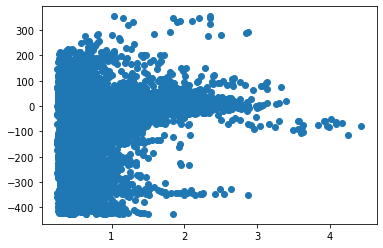

In [60]:
plt.scatter(wave_height_train_clean['wvht'],wave_height_train_clean['dir_dif'])

* Looking at the correlations between various numerical columns

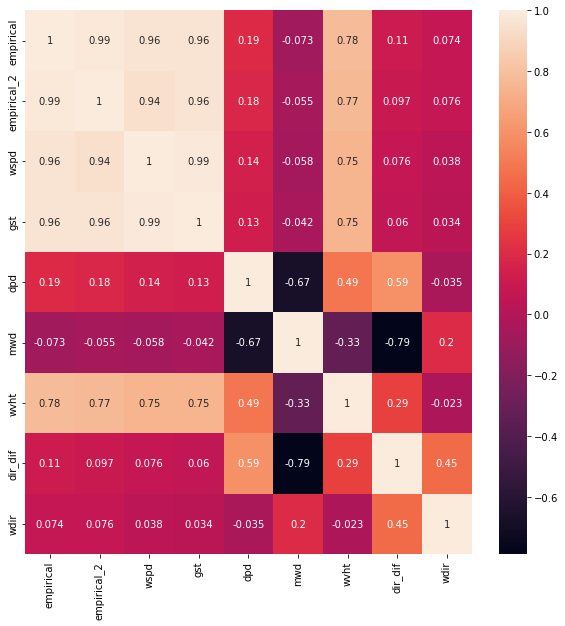

In [61]:
# Creating a list of column names of numerical features
cols = ['empirical','empirical_2','wspd','gst','dpd','mwd','wvht','dir_dif','wdir']

# Plotting the correlations on a heatmap
plt.figure(figsize = (10, 10))
sns.heatmap(wave_height_train_clean[cols].corr(), annot = True)

plt.show()

<a id='3'></a>
## 3. Linear Regression model

=> [Return to the top](#1) <=

Now that correlations and other numerical features have been identified, modelling can begin. The first model to begin with is Linear regression
#### 3.1. Functions for the model

In [62]:
def print_metrics(data_pred,data_observ):
    '''
    Function that prints the MAE, RMSE, and R^2 value for data predictions and the actual data
    ----------
    Parameters:
    data_pred : pandas series/dataframe/list
        - Model predictions 
    data_observ : pandas series/dataframe/list
        - Observed data to compare it with
    --------
    Prints:
        - MAE
        - RMSE
        - R^2
    '''
    # Creates the relevant metrics
    mae = metrics.mean_absolute_error(data_observ,data_pred)
    rmse = statsmodels.tools.eval_measures.rmse(data_observ, data_pred)
    r2 = metrics.r2_score(data_observ,data_pred)
    
    # Prints the relevant metrics
    print('MAE: ' + str(mae))
    print('RMSE: ' + str(rmse))
    print('R^2: ' + str(r2))

class linear_regression_model:
    def __init__(self,data,features,target):
        '''
        Creates an object for the data, features, target, and builds a linear regression model
        ---------
        Parameters:
        data : pandas dataframe
            - Dataframe that contains the data used to create the model 
        features : list
            - List of columns to be used as features
        target : string
            - Name of column in data to be used as target
        '''
        # Creates an object with the following values
        self.features = features
        self.target = target
        self.X = data[features]
        self.y = data[target]
        
        # Creates the model
        lin_reg = sm.OLS(self.y, self.X)
        self.results = lin_reg.fit()
        
    def predict(self,pred_data):
        '''
        Function for obtaining metrics comparing the predictions to the real numbers
        ----------
        Parameters:
        pred_data : pandas data frame
            - data frame containing observations to compare to predictions
        ----------
        Prints:
            - MAE: Mean absolute error
            - RMSE: root mean squared error
            - R-squared: r-squared value
        '''
        # Adds the pred_data to the object
        self.data = pred_data
        
        # Creates predictions based on the model
        self.data['y_pred'] = self.results.predict(self.data[self.features])
        
        # Creates metrics
        mae = metrics.mean_absolute_error(self.data[self.target],self.data['y_pred'])
        rmse = statsmodels.tools.eval_measures.rmse(self.data[self.target], self.data['y_pred'])
        r2 = self.results.rsquared
        
        # Prints metrics
        print('MAE: ' + str(mae))
        print('RMSE: ' + str(rmse))
        print('R-squared: ' + str(r2))
        
    def plot(self,i_start = None,i_end = None,date = None):
        '''
        Function that plots the model predictions to the real numbers
        ---------
        Parameters:
            - Specifies the index range to plot
        i_start : int
            - Start of the range
        i_end : int
            - End of the range
        ---------
        Plots:
            - Wave height prediction compared to actual wave height
        '''
        # Creates dataframes for plotting the predictions and observations
        date_plot = self.data[['wvht','date']]
        date_plot['y_pred'] = self.data['y_pred']
        
        # Sets the index to the date
        date_plot.set_index('date',inplace = True)
        date_plot.sort_index(inplace = True)
        
        # Creates the plot
        plt.figure(figsize=(12,9))
        
        # If the index is specified, plots the data according during the time specified
        if i_start != None and i_end != None:
            plt.plot(date_plot['wvht'].iloc[i_start:i_end])
            plt.plot(date_plot['y_pred'].iloc[i_start:i_end])
            
        # If the date is specified, 
        elif date != None:
            plt.plot(date_plot['wvht'].loc[date])
            plt.plot(date_plot['y_pred'].loc[date])
            
        # If the index is not specified, all of the date is plotted
        else:
            plt.plot(date_plot['wvht'])
            plt.plot(date_plot['y_pred'])
        
        # Legend, axes and title
        plt.legend(['Wave height prediction','Wave height'])
        plt.xlabel('Date')
        plt.ylabel('Height (m)')
        plt.title('Plots of wave height as derived from the equation and the actual wave height')
        
    

* Building the Linear Regression model

In [63]:
# Creating a list of feature columns
feature_cols = list(wave_height_train_clean.columns)

# Removing the target, date and prediction column
for col in ['wvht','y_pred','date']:
    try:
        feature_cols.remove(col)
    except:
        print(col,' is already removed')


y_pred  is already removed


In [64]:
# Creating a linear regression model using the features columns
model_1 = linear_regression_model(wave_height_train_clean,feature_cols,'wvht')


In [65]:
# Assessing the performance of the model
model_1.predict(wave_height_train_clean)

MAE: 0.1545853568569033
RMSE: 0.21376069232384234
R-squared: 0.8663074893152911


In [66]:
# Summary of the model
model_1.results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wvht   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     2562.
Date:                Thu, 10 Mar 2022   Prob (F-statistic):               0.00
Time:                        11:08:55   Log-Likelihood:                 737.19
No. Observations:                5947   AIC:                            -1442.
Df Residuals:                    5931   BIC:                            -1335.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
#yy             0.0015      0.000      4.196      0.000       0.001       0.002
mm          -9.542e-05      0.002     -0.045      0.964      -0.004       0.004
dd              0.0004      0.000      1.328      0.184      -0.000       0.001
hh              0.0035      0.000      8.738      0.000       0.003       0.004
mins         3.687e-05   8.79e-06      4.196      0.000    1.96e-05    5.41e-05
wdir        -2.966e-05   2.14e-05     -1.386      0.166   -7.16e-05    1.23e-05
wspd           -0.0702      0.018     -3.956      0.000      -0.105      -0.035
gst             0.1322      0.016      8.425      0.000       0.101       0.163
dpd            -0.0133      0.003     -3.945      0.000      -0.020      -0.007
apd             0.4834      0.007     71.589      0.000       0.470       0.497
mwd          8.492e-05   1.99e-05      4.257      0.000    4.58e-05       0.000
pres           -0.0045      0.001     -6.617      0.000      -0.006      -0.003
atmp            0.0001      0.000      0.459      0.646      -0.000       0.001
wtmp           -0.0100      0.001     -7.323      0.000      -0.013      -0.007
dewp        -4.679e-06   1.53e-05     -0.306      0.760   -3.47e-05    2.53e-05
vis          7.301e-05   1.74e-05      4.196      0.000    3.89e-05       0.000
tide         7.301e-05   1.74e-05      4.196      0.000    3.89e-05       0.000
empirical       0.3507      0.038      9.348      0.000       0.277       0.424
empirical_2    -0.1783      0.027     -6.704      0.000      -0.230      -0.126
dir_dif        -0.0001   1.53e-05     -7.497      0.000      -0.000   -8.46e-05
==============================================================================
Omnibus:                      622.342   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4538.397
Skew:                          -0.210   Prob(JB):                         0.00
Kurtosis:                       7.259   Cond. No.                     6.80e+20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.27e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6402: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  key,


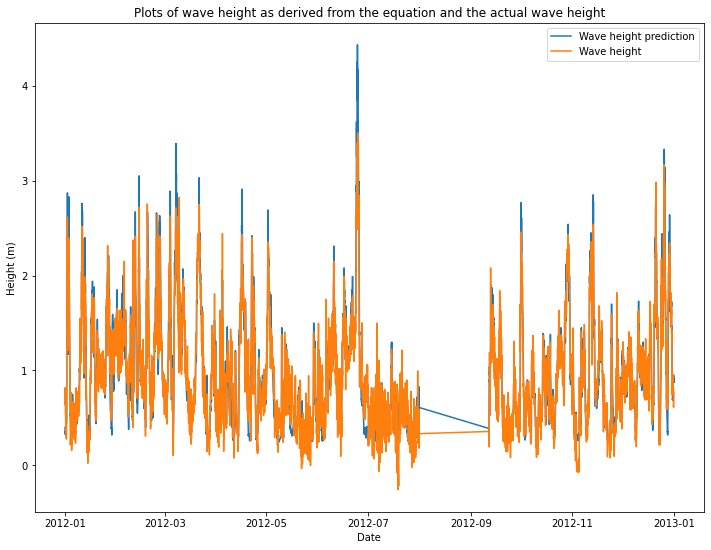

In [67]:
# Creating a plot of the predictions compared to the observed wave height
model_1.plot()

#### 3.2. Testing Linear Regression model
* Importing the test data

In [68]:
# Importing the test data
test_df = pd.read_csv('wave_height_test.csv')

In [69]:
# Quick look at the dataframe
test_df.head()

Unnamed: 0   #YY  MM  DD  hh  mm  WDIR  WSPD   GST  WVHT   DPD   APD  MWD  \
0        7272  2012  12   4   3  50   140   8.5  10.0  1.01  5.00  4.09  137   
1        2225  2012   4   2  20  50   147   6.8   7.6  0.55  4.17  3.58  999   
2         334  2012   1  14  23  50   234   3.7   6.3  0.26  3.45  3.52  999   
3        5866  2012  10   6  12  50     4   4.5   5.1  0.39  4.76  3.97  999   
4        1501  2012   3   3  15  50   214   8.4  10.2  1.59  7.69  5.57  198   

     PRES  ATMP  WTMP   DEWP   VIS  TIDE  
0  1021.9  23.0  23.5   20.8  99.0  99.0  
1  1011.0  24.6  26.4  999.0  99.0  99.0  
2  1028.9  13.4  19.2  999.0  99.0  99.0  
3  1015.1  26.2  27.5   24.7  99.0  99.0  
4  1008.1  22.1  20.9  999.0  99.0  99.0

* Cleaning the test dataframe

In [70]:
test_df_clean = clean(test_df)

Columns are fixed
Columns are fixed
Columns are fixed
Columns are fixed
Columns are fixed
Columns are fixed
Columns are fixed
Columns are fixed
Columns are fixed
Columns are fixed
Columns are fixed
Columns are fixed
Columns are fixed
Columns are fixed
Columns are fixed
Columns are fixed
Columns are fixed
Columns are fixed


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [71]:
test_df_clean.head()

#yy  mm  dd  hh  mins  wdir  wspd   gst  wvht   dpd   apd         mwd  \
index                                                                           
7272   2012  12   4   3    50   140   8.5  10.0  1.01  5.00  4.09  137.000000   
2225   2012   4   2  20    50   147   6.8   7.6  0.55  4.17  3.58  429.503679   
334    2012   1  14  23    50   234   3.7   6.3  0.26  3.45  3.52  429.503679   
5866   2012  10   6  12    50     4   4.5   5.1  0.39  4.76  3.97  429.503679   
1501   2012   3   3  15    50   214   8.4  10.2  1.59  7.69  5.57  198.000000   

         pres  atmp  wtmp   dewp   vis  tide                date  
index                                                             
7272   1021.9  23.0  23.5   20.8  99.0  99.0 2012-12-04 03:00:00  
2225   1011.0  24.6  26.4  999.0  99.0  99.0 2012-04-02 20:00:00  
334    1028.9  13.4  19.2  999.0  99.0  99.0 2012-01-14 23:00:00  
5866   1015.1  26.2  27.5   24.7  99.0  99.0 2012-10-06 12:00:00  
1501   1008.1  22.1  20.9  999.0  99.0  99.0 2012-03-03 15:00:00

* Quick test of the first model

In [72]:
# Feature engineering the test 
test_df_clean = feature_eng(test_df_clean)

In [73]:
# Quick look at the engineered dataframe
test_df_clean.head()

#yy  mm  dd  hh  mins  wdir  wspd   gst  wvht   dpd  ...    pres  \
index                                                        ...           
7272   2012  12   4   3    50   140   8.5  10.0  1.01  5.00  ...  1021.9   
2225   2012   4   2  20    50   147   6.8   7.6  0.55  4.17  ...  1011.0   
334    2012   1  14  23    50   234   3.7   6.3  0.26  3.45  ...  1028.9   
5866   2012  10   6  12    50     4   4.5   5.1  0.39  4.76  ...  1015.1   
1501   2012   3   3  15    50   214   8.4  10.2  1.59  7.69  ...  1008.1   

       atmp  wtmp   dewp   vis  tide                date  empirical  \
index                                                                 
7272   23.0  23.5   20.8  99.0  99.0 2012-12-04 03:00:00   1.988532   
2225   24.6  26.4  999.0  99.0  99.0 2012-04-02 20:00:00   1.272661   
334    13.4  19.2  999.0  99.0  99.0 2012-01-14 23:00:00   0.376789   
5866   26.2  27.5   24.7  99.0  99.0 2012-10-06 12:00:00   0.557339   
1501   22.1  20.9  999.0  99.0  99.0 2012-03-03 15:00:00   1.942018   

      empirical_2     dir_dif  
index                          
7272     2.752294    3.000000  
2225     1.589725 -282.503679  
334      1.092385 -195.503679  
5866     0.715872 -425.503679  
1501     2.863486   16.000000  

[5 rows x 22 columns]

In [74]:
# Predicting wave height on the test data using model_1 
model_1.predict(test_df_clean)

MAE: 0.15258098751186744
RMSE: 0.2127312408206142
R-squared: 0.8663074893152911


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6402: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  key,


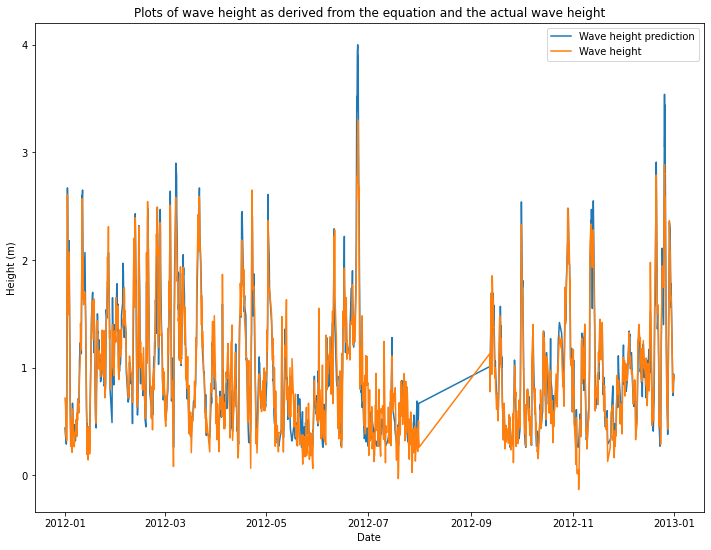

In [75]:
# Making a plot of the test data predictions and observation comparison
model_1.plot()

<a id='4'></a>
## 4. ARIMA model

=> [Return to the top](#1) <=

Now that the linear regression model has been established, the ARIMA model can be built. First, since the model only relies on the previous instances of wave height, a new dataframe will be created that only includes the wave height. 

The data will first be explored in for various properties essential to building an ARIMA model

* 4.1. Train - test split
* 4.2. Seasonal decomposition
* 4.3. Autocorrelation
* 4.4. Partial autocorrelation

#### 4.1. Train - test split
Since ARIMA is a time series model, it will use the previous instances to forecast the next instance. This means that the train - test split used for linear regression will not be appropriate for ARIMA, since that train-test split took random points of data from the data set for the test set. For ARIMA, it will be necessary to make a new train - test split, so that the test set is comprised of later data instances, and the training of the earlier instances.


In [76]:
# Original data set
wave_height_df.head()

#YY  MM  DD  hh  mm WDIR WSPD  GST  WVHT   DPD   APD  MWD    PRES  ATMP  \
0  2011  12  31  23  50   73  1.4  1.8  0.44  5.56  4.87  227  1021.7  17.1   
1  2012  01  01  00  50   87  2.5  3.1  0.40  5.26  4.69  217  1022.0  18.3   
2  2012  01  01  01  50  115  3.6  4.0  0.39  5.56  4.70  198  1022.2  19.2   
3  2012  01  01  02  50  117  3.8  4.5  0.34  5.26  4.63  215  1022.4  19.8   
4  2012  01  01  03  50  129  4.5  5.2  0.35  5.00  4.66  210  1022.4  20.1   

   WTMP   DEWP   VIS   TIDE  
0  20.3  999.0  99.0  99.00  
1  20.2  999.0  99.0  99.00  
2  20.3  999.0  99.0  99.00  
3  20.3  999.0  99.0  99.00  
4  20.3  999.0  99.0  99.00

In [77]:
# Cleaning the data set 
ts_wave_height = clean(wave_height_df)

No index column
Changed  #yy  to int
Changed  mm  to int
Changed  dd  to int
Changed  hh  to int
Changed  mins  to int
Changed  wdir  to int
Changed  wspd  to float
Changed  gst  to float
Changed  wvht  to float
Changed  dpd  to float
Changed  apd  to float
Changed  mwd  to int
Changed  pres  to float
Changed  atmp  to float
Changed  wtmp  to float
Changed  dewp  to float
Changed  vis  to float
Changed  tide  to float


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [78]:
ts_wave_height.head()

#yy  mm  dd  hh  mins  wdir  wspd  gst  wvht   dpd   apd    mwd    pres  \
0  2011  12  31  23    50    73   1.4  1.8  0.44  5.56  4.87  227.0  1021.7   
1  2012   1   1   0    50    87   2.5  3.1  0.40  5.26  4.69  217.0  1022.0   
2  2012   1   1   1    50   115   3.6  4.0  0.39  5.56  4.70  198.0  1022.2   
3  2012   1   1   2    50   117   3.8  4.5  0.34  5.26  4.63  215.0  1022.4   
4  2012   1   1   3    50   129   4.5  5.2  0.35  5.00  4.66  210.0  1022.4   

   atmp  wtmp   dewp   vis  tide                date  
0  17.1  20.3  999.0  99.0  99.0 2011-12-31 23:00:00  
1  18.3  20.2  999.0  99.0  99.0 2012-01-01 00:00:00  
2  19.2  20.3  999.0  99.0  99.0 2012-01-01 01:00:00  
3  19.8  20.3  999.0  99.0  99.0 2012-01-01 02:00:00  
4  20.1  20.3  999.0  99.0  99.0 2012-01-01 03:00:00

* Since ARIMA is a time series model, the only data needed are the date and time of the recording and the waveheight, so only the 'date' and 'wvht' columns

In [79]:
# Creating a new dataframe with just the wave height and date
y = ts_wave_height[['wvht','date']]

# Setting the index to date
y.set_index('date',inplace = True)

y.sort_index(inplace = True)

# Train test splitting the data
ts_wave_height_train, ts_wave_height_test = train_test_split(y, test_size = 0.2, shuffle = False)

In [80]:
# Looking at the newly created test data
ts_wave_height_train.head()

wvht
date                     
2011-12-31 23:00:00  0.44
2012-01-01 00:00:00  0.40
2012-01-01 01:00:00  0.39
2012-01-01 02:00:00  0.34
2012-01-01 03:00:00  0.35

#### 4.2. Seasonal decomposition

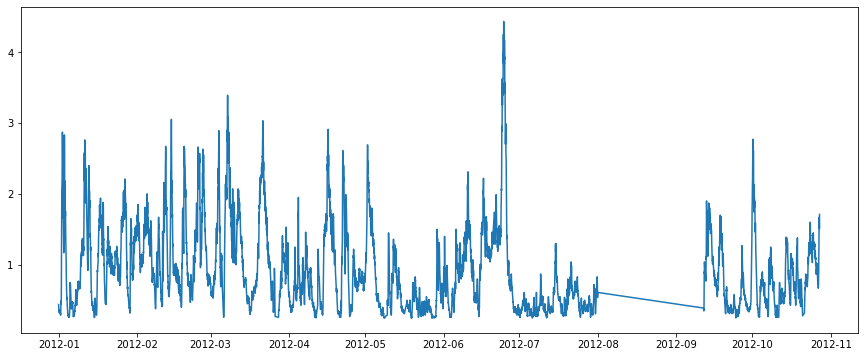

In [81]:
# Plotting the height over time of this dataframe
plt.figure(figsize = (15, 6))
plt.plot(ts_wave_height_train)

plt.show()

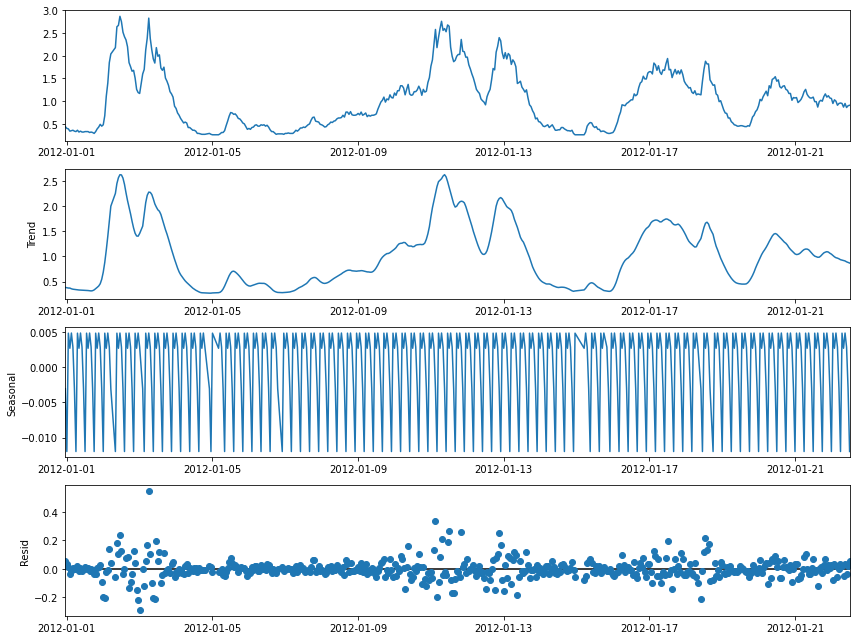

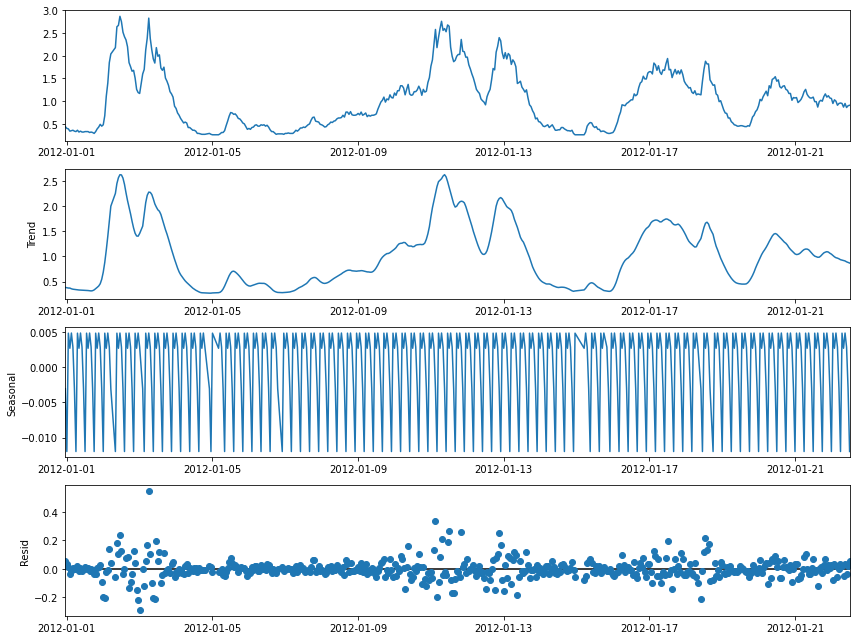

In [82]:
# Plotting the seasonal decomposition of the data
plt.rcParams['figure.figsize'] = (12, 9)

decomp = seasonal_decompose(ts_wave_height_train[:500], model='ad',extrapolate_trend='freq', period=6)
decomp.plot()

#### 4.2. Autocorrelation
In order to determine the order of the ARIMA model, the plot of the autocorrelation will be made

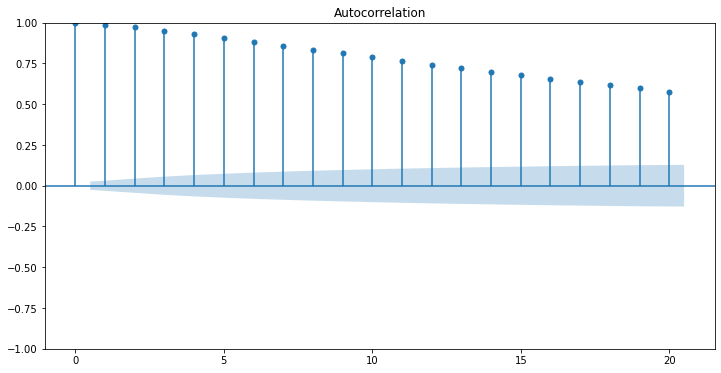

In [83]:
plt.rcParams['figure.figsize'] = (12, 6)
plot_acf(ts_wave_height_train, lags = 20);

Since the autocorrelation plot trails off, this means that either the model will be AR or ARMA
#### 4.3. Partial Autocorrelation 
The plot of the partial autocorrelation function will further determine the order of the ARIMA model

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


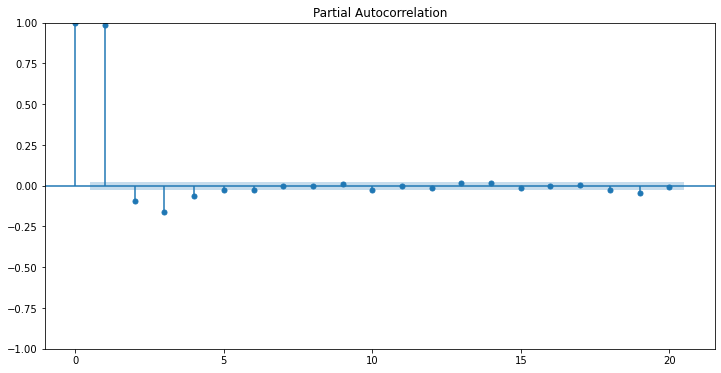

In [84]:
plot_pacf(ts_wave_height_train, lags = 20);

Since the partial autocorrelation plot cuts off at the 2nd lag, the appropriate model will an AR model of order 2. So the order of the ARIMA model will be (2,1,0), corresponding to (p,k,q).
<a id='4.4'></a>
#### 4.4. Model 
* Defining functions

In [85]:
def make_equation(model):
    '''
    Creates the equation for predicting data using ARIMA
    ----------
    Parameters:
    model : ar
        - ARIMA model 
    ----------
    Returns:
    equation : function()
        - Function that makes a prediction
    params : list
        - List of the parameters
    '''
    # Creates a range from 1 to the number of parameters of the model
    param_range = range(1,len(model.params))
    
    # Obtains int versions of the lags of the parameters
    params = [model.params['ar.L'+str(x)] for x in param_range]
    
    # The model didn't work unless the first parameter was multiplied by 10 (not sure why)
    params[0] = params[0]*10
    
    # Obtains the sigma squared parameter
    s2 = model.params.sigma2
    
    # Creates a new function for making predictions based on the parameters from the model
    def equation(data):
        '''
        Makes a prediction using the model params obtained in the make_equation() function to make a
        prediction
        ----------
        Parameters:
        data : pandas dataframe
            - Data to be used for making a prediction
        ----------
        Returns:
        pred : float
            - Prediction using the model and data
        '''
        # Sets the pred value to 0
        pred = 0
        
        # Loops through the number of parameters in the model
        for q in param_range:
            
            # Adds the parameter multiplied by the lagged data value
            pred += (params[q-1] * data[-q])
            
        # Adds the sigma squared value
        pred += s2 * np.random.random()
        return pred 
    
    return equation,params

def arima_plot(pred_data,observe_data,i_start = None,i_end = None,date = None):
    '''
    Makes a plot of the predictions and the real data in order for a visual comparison
    ----------
    Parameters:
    date : string (format 'yyyy-mm')
        - year and month of the data to be plotted
    ----------
    Plots:
    Plots the real data and the predicted data for visual comparison
    '''
    # Creates data frame for plotting
    plot_data = observe_data.reset_index()
    
    # Adds predictions to the data frame
    plot_data['y_pred'] = pred_data
    
    # Adds the dates to the index
    plot_data = plot_data.set_index(plot_data['date'])
        
    # Establish the figure size
    plt.figure(figsize=(12,9))
    
    # If the index range is specified, the data in the index range will be plotted
    if i_start != None and i_end != None:
        plot_data['wvht'].iloc[i_start:i_end].plot(c = 'blue')
        plot_data['y_pred'].iloc[i_start:i_end].plot(c = 'red', style = '--')
            
    # If the date is specified, the data in the date is plotted
    elif date != None:
        plot_data['wvht'].loc[date].plot(c = 'blue')
        plot_data['y_pred'].loc[date].plot(c = 'red', style = '--')
        
    # If neither the index range or date is specified, the whole date is plotted
    else:
        plot_data['wvht'].plot(c = 'blue')
        plot_data['y_pred'].plot(c = 'red', style = '--')
            
    # Adding labels, title and legend
    plt.xlabel('Date')
    plt.ylabel('Wave height')
    plt.title('Plot of model predictions and observed data')
    plt.legend(labels=('Observed wave height','Predicted wave height'))
        
    plt.show()

class arima_model:
    def __init__(self,data,model_order,model_type = 'ARIMA',seasonal_order = ()):
        '''
        Builds an arima model according to the order and data
        ---------
        Params:
        data : pandas dataframe
            - data for fitting the model
        model_order : array
            - order of the ARIMA model
        model_type = 'ARIMA' : str
            - type of model to use, either ARIMA or SARIMAX, default is ARIMA
        seasonal_order = () : tuple
            - Tuple of the seasonal order, only relevant if SARIMAX is specified
        '''
        # Stores the data
        self.data = data
        
        # Stores the model type
        self.model_type = model_type
        
        # If the model type is ARIMA, an ARIMA model will be built
        if model_type == 'ARIMA':
            
            # Builds an ARIMA model and fits it to the data
            model = ARIMA(data, order = model_order)
            self.ar = model.fit()
            
        # If the model type is SARIMAX, a SARIMAX model will be built
        elif model_type == 'SARIMAX':
            
            # Builds a SARIMAX model and fits it to the data
            model = SARIMAX(data, order = model_order, seasonal_order = seasonal_order)
            self.ar = model.fit()
            
        # If the model type is invalid, no model will be built
        else:
            print('Model type is invalid')
        
    def predict(self,start,end,use_data = 0):
        '''
        Creates predictions based on the ARIMA model
        ----------
        Parameters: 
        start : int
            - Index in the data frame to start making the prediction
        end : int
            - Index to 
        ----------
        Returns:
        pred_data : pandas dataframe
            - Dataframe containing the observed wave height and predictions
        '''
        # Create equation
        self.eq,params = make_equation(self.ar)
        
        # Creates an empty list to fill with predictions
        list_of_preds = []
        
        # Error handling (this eased the process of making the code)
        if start < len(params):
            print('Start value is invalid')
            
        elif end > len(self.data) + 1:
            print('End value is out of range')
        
        else:
            if type(use_data) == int:
                use_data = self.data
                
            # Looping through the index range between start and end
            for index in range(start,end):
                # Creates a prediction value
                pred = self.eq(use_data['wvht'].iloc[start - len(params) + index:start + index])
                
                # Adds the prediction to the list
                list_of_preds.append(pred)
            
             # Adds the predictions to the dataframe
            self.pred_data = pd.DataFrame(data = list_of_preds,columns = ['y_pred'])
            
            # Returns the dataframe
            return self.pred_data
    

* Building the ARIMA model

In [86]:
# Creating an ARIMA model with order (2,1,0)
model_2 = arima_model(ts_wave_height_train[['wvht']],(2,1,0))

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [87]:
# Create the dataframe with predictions and observations over a period from 2 to the end of the dataframe
arima_preds = model_2.predict(2,len(ts_wave_height_train)-1)

In [88]:
# Returning the relevant metrics on the predictions
print_metrics(arima_preds,ts_wave_height_train[['wvht']].iloc[2:-1])

MAE: 0.08034191487153572
RMSE: [0.11196891]
R^2: 0.963660919425525


Text(0, 0.5, 'Wave height (m)')

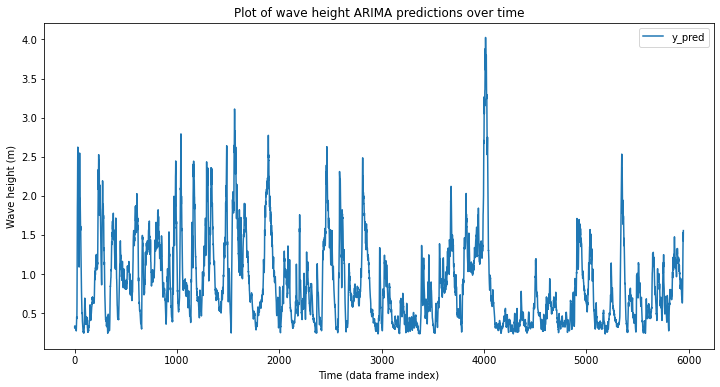

In [89]:
# Plot of the predictions
model_2.pred_data.plot()

plt.title('Plot of wave height ARIMA predictions over time')
plt.xlabel('Time (data frame index)')
plt.ylabel('Wave height (m)')

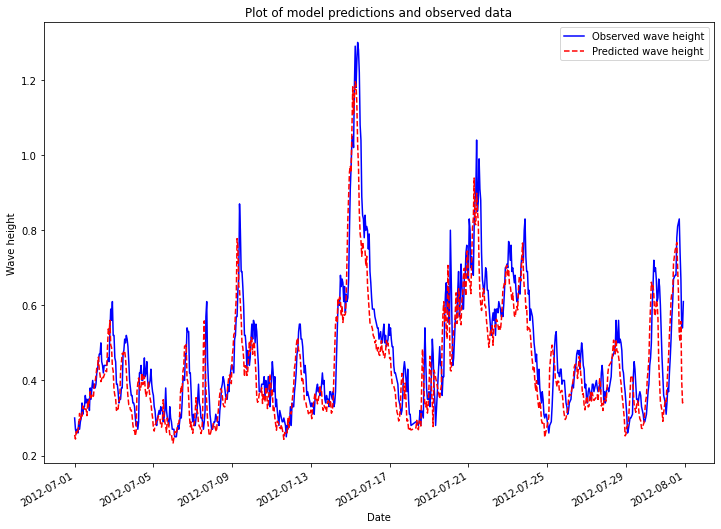

In [90]:
# Creating a plot of the model's predictions compared to the observed data
arima_plot(arima_preds,ts_wave_height_train,date = '2012-07')

<a id='5'></a>
## 5. Improving on the models: Linear regression

=> [Return to the top](#1) <=
#### 5.1. K-fold Cross validation for Linear Regression

* Defining functions for cross validation

In [91]:
# Defining the cross validation method
cv = KFold(n_splits=10, random_state=1, shuffle=True)

def cross_validation(model,data,features,target):
    '''
    Generates a list of MAE scores for various models created in cross validation
    ---------
    Arguments
    model : model
        - The type of model to be used in the cross validation
    data : pandas dataframe
        - The data to be used in cross validation
    features : list
        - List of column names in the data to be used as features in the model
    target : str
        - Target column to be predicting
    '''
    # Defines X train and y train for the model to be cross validated
    X_train = data[features]
    y_train = data[target]
    # Generates the MAE scores for different models
    scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)
    return scores
    
def print_mae_rmse(scores):
    '''
    Returns the MAE and RMSE for the cross validation MAE scores
    ----------
    Parameters:
    scores : list of floats
        - list of the MAE scores in each segment of data from the cross validation
    ----------
    Prints:
    np.mean(np.absolute(scores)) : float
        - MAE
    np.sqrt(np.mean(np.absolute(scores))) : float
        - RMSE
    '''
    print('MAE:',np.mean(np.absolute(scores)))
    print('RMSE:',np.sqrt(np.mean(np.absolute(scores))))
    
def return_mae_rmse(scores):
    '''
    Returns the MAE and RMSE for the cross validation MAE scores
    ----------
    Parameters:
    scores : list of floats
        - list of the MAE scores in each segment of data from the cross validation
    ----------
    Prints:
    np.mean(np.absolute(scores)) : float
        - MAE
    np.sqrt(np.mean(np.absolute(scores))) : float
        - RMSE
    '''
    return np.mean(np.absolute(scores)),np.sqrt(np.mean(np.absolute(scores)))

* Sample set of features

In [92]:
# Feature columns to be used in the cross validation
feature_cols = ['empirical','wspd','gst','dpd','mwd']

# Generating the lin reg scores
lin_reg_scores = cross_validation(LinearRegression(),wave_height_train_clean,feature_cols,'wvht')

In [93]:
# Assessing the scores obtained by the cross validation
print_mae_rmse(lin_reg_scores)

MAE: 0.21689711250133836
RMSE: 0.4657221408751557


* Testing all features to find the best ones to include (prepare for a lot of warning messages!)

In [94]:
# Making a list of all the features to use in cross-validation
all_feats = list(wave_height_train_clean.columns)
all_feats.remove('wvht')

# Creating empty lists to fill with feature combinations with their corresponding MAE and RMSE
list_feat_combs = []
list_mae = []
list_rmse = []

# Looping through all the possible feature combinations
for feat_1 in range(0,len(list(all_feats))):
     for feat_2 in range(feat_1,len(list(all_feats))):
            list_feat_combs.append(all_feats[feat_1:feat_2])
            # Obtains the MAE and RMSE scores
            a,b = return_mae_rmse(
                cross_validation(LinearRegression(),wave_height_train_clean,all_feats[feat_1:feat_2],'wvht'))
            # Adds the MAE and RMSE to their respective lists
            list_mae.append(a)
            list_rmse.append(b)
    

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_base.py", line 663, in fit
    X, y, accept_sparse=accept_sparse, y_numeric=True, multi_output=True
  File "/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 576, in _validate_data
    X, y = check_X_y(X, y, **check_param

* Transforming the scores into a dataframe 

In [95]:
# Zipping the data stored in the lists
zipped = list(zip(list_feat_combs,list_mae,list_rmse))

# Creating a dataframe of the zipped data 
data_lin_reg = pd.DataFrame(zipped,columns = ['feat_combs','mae','rmse'])

# Looking at the data
data_lin_reg.head()

feat_combs       mae      rmse
0                 []       NaN       NaN
1              [#yy]  0.455179  0.674669
2          [#yy, mm]  0.453215  0.673212
3      [#yy, mm, dd]  0.453656  0.673540
4  [#yy, mm, dd, hh]  0.453734  0.673598

* Since the for loop includes empty feature combination lists, they will be omitted from the dataframe

In [96]:
# Mapping a lambda function to the data frame to remove any row where the 'feat_combs' is 0
data_lin_reg = data_lin_reg[data_lin_reg['feat_combs'].map(lambda x: len(x) > 0 )]


* Some null values are included in the dataframe, so they will be dropped

In [97]:
# Dropping the null values
data_lin_reg.dropna(inplace = True)


In [98]:
# Quick look at fixed dataframe
data_lin_reg.head(10)

feat_combs       mae      rmse
1                                               [#yy]  0.455179  0.674669
2                                           [#yy, mm]  0.453215  0.673212
3                                       [#yy, mm, dd]  0.453656  0.673540
4                                   [#yy, mm, dd, hh]  0.453734  0.673598
5                             [#yy, mm, dd, hh, mins]  0.453734  0.673598
6                       [#yy, mm, dd, hh, mins, wdir]  0.453406  0.673355
7                 [#yy, mm, dd, hh, mins, wdir, wspd]  0.287166  0.535879
8            [#yy, mm, dd, hh, mins, wdir, wspd, gst]  0.285448  0.534273
9       [#yy, mm, dd, hh, mins, wdir, wspd, gst, dpd]  0.224525  0.473840
10  [#yy, mm, dd, hh, mins, wdir, wspd, gst, dpd, ...  0.157608  0.396999

* Finding the feature combinations with the lowest mae

In [99]:
data_lin_reg.sort_values(by = 'mae',ascending = True).head(10)

feat_combs       mae      rmse
11  [#yy, mm, dd, hh, mins, wdir, wspd, gst, dpd, ...  0.157254  0.396552
32  [mm, dd, hh, mins, wdir, wspd, gst, dpd, apd, ...  0.157254  0.396552
12  [#yy, mm, dd, hh, mins, wdir, wspd, gst, dpd, ...  0.157443  0.396791
33  [mm, dd, hh, mins, wdir, wspd, gst, dpd, apd, ...  0.157443  0.396791
71         [hh, mins, wdir, wspd, gst, dpd, apd, mwd]  0.157475  0.396831
55  [dd, hh, mins, wdir, wspd, gst, dpd, apd, mwd,...  0.157488  0.396847
52     [dd, hh, mins, wdir, wspd, gst, dpd, apd, mwd]  0.157493  0.396854
74  [hh, mins, wdir, wspd, gst, dpd, apd, mwd, pre...  0.157503  0.396866
58  [dd, hh, mins, wdir, wspd, gst, dpd, apd, mwd,...  0.157531  0.396902
56  [dd, hh, mins, wdir, wspd, gst, dpd, apd, mwd,...  0.157531  0.396902

In [100]:
# Printing the list of features for the top 10 best feature combinations
for feats in data_lin_reg.sort_values(by = 'mae',ascending = True).feat_combs.head(10):
    print(feats)

['#yy', 'mm', 'dd', 'hh', 'mins', 'wdir', 'wspd', 'gst', 'dpd', 'apd', 'mwd']
['mm', 'dd', 'hh', 'mins', 'wdir', 'wspd', 'gst', 'dpd', 'apd', 'mwd']
['#yy', 'mm', 'dd', 'hh', 'mins', 'wdir', 'wspd', 'gst', 'dpd', 'apd', 'mwd', 'pres']
['mm', 'dd', 'hh', 'mins', 'wdir', 'wspd', 'gst', 'dpd', 'apd', 'mwd', 'pres']
['hh', 'mins', 'wdir', 'wspd', 'gst', 'dpd', 'apd', 'mwd']
['dd', 'hh', 'mins', 'wdir', 'wspd', 'gst', 'dpd', 'apd', 'mwd', 'pres', 'atmp', 'wtmp']
['dd', 'hh', 'mins', 'wdir', 'wspd', 'gst', 'dpd', 'apd', 'mwd']
['hh', 'mins', 'wdir', 'wspd', 'gst', 'dpd', 'apd', 'mwd', 'pres', 'atmp', 'wtmp']
['dd', 'hh', 'mins', 'wdir', 'wspd', 'gst', 'dpd', 'apd', 'mwd', 'pres', 'atmp', 'wtmp', 'dewp', 'vis', 'tide']
['dd', 'hh', 'mins', 'wdir', 'wspd', 'gst', 'dpd', 'apd', 'mwd', 'pres', 'atmp', 'wtmp', 'dewp']


* Checking for multicollinearity 

In [101]:
# Creating an empty list of the best features
best_feats = []

# Looping through the feature lists in the top 10 best feature lists
for feat_list in data_lin_reg.sort_values(by = 'mae',ascending = True).feat_combs.head(10):
    # Looping through each feature in the list
    for feat in feat_list:
        # Adds the feature to the list of best features if its not in there already
        if feat not in best_feats:
            best_feats.append(feat)


* Creating the best Linear Regression model

In [102]:
# Checking the model for multicollinearity
model_mc_check = linear_regression_model(wave_height_train_clean,best_feats,'wvht')


In [103]:
# Cross validation on linear regression with these feature columns
score_list = cross_validation(LinearRegression(),wave_height_train_clean,best_feats,'wvht')

# Print MAE and RMSE
print_mae_rmse(score_list)

MAE: 0.15755969006070022
RMSE: 0.3969378919436896


In [104]:
# Summary of the model to check for multicollinearity
model_mc_check.results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wvht   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     2861.
Date:                Thu, 10 Mar 2022   Prob (F-statistic):               0.00
Time:                        11:09:21   Log-Likelihood:                 652.05
No. Observations:                5947   AIC:                            -1276.
Df Residuals:                    5933   BIC:                            -1182.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
#yy            0.0016      0.000      4.567      0.000       0.001       0.002
mm             0.0006      0.002      0.285      0.776      -0.004       0.005
dd             0.0005      0.000      1.436      0.151      -0.000       0.001
hh             0.0036      0.000      8.874      0.000       0.003       0.004
mins        4.068e-05   8.91e-06      4.567      0.000    2.32e-05    5.81e-05
wdir          -0.0001   3.14e-05     -4.025      0.000      -0.000   -6.48e-05
wspd           0.0630      0.007      9.175      0.000       0.050       0.076
gst            0.0488      0.006      8.401      0.000       0.037       0.060
dpd           -0.0141      0.003     -4.126      0.000      -0.021      -0.007
apd            0.5022      0.007     75.701      0.000       0.489       0.515
mwd            0.0002   2.87e-05      7.991      0.000       0.000       0.000
pres          -0.0050      0.001     -7.244      0.000      -0.006      -0.004
atmp        6.656e-06      0.000      0.030      0.976      -0.000       0.000
wtmp          -0.0095      0.001     -6.894      0.000      -0.012      -0.007
dewp       -1.295e-06   1.55e-05     -0.084      0.933   -3.17e-05    2.91e-05
vis         8.055e-05   1.76e-05      4.567      0.000     4.6e-05       0.000
tide        8.055e-05   1.76e-05      4.567      0.000     4.6e-05       0.000
==============================================================================
Omnibus:                      489.442   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3009.633
Skew:                          -0.050   Prob(JB):                         0.00
Kurtosis:                       6.484   Cond. No.                     6.13e+31
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.92e-54. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

* Several features need to be removed due to multicollinearity

In [105]:
# List of features that need to be removed
remove_feats = ['atmp','dewp','mm','dd','apd','gst','#yy','mins','vis','tide']

# Looping through the features that need to be removed
for feat in remove_feats:
    # Removes the feature if it's in the list of best features
    try:
        best_feats.remove(feat)
    except:
        print(feat, 'already removed')
    

print(best_feats)

['hh', 'wdir', 'wspd', 'dpd', 'mwd', 'pres', 'wtmp']


In [106]:
# Checking the model having removed the feature causing multicollinearity
model_mc_check = linear_regression_model(wave_height_train_clean,best_feats,'wvht')


In [107]:
# List of scores for cross validation of the best linear regression model
score_list = cross_validation(LinearRegression(),wave_height_train_clean,best_feats,'wvht')

# Prints MAE and RMSE
print_mae_rmse(score_list)

MAE: 0.22501999144198517
RMSE: 0.47436272138732105


In [108]:
# Summary of the best model
model_mc_check.results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   wvht   R-squared (uncentered):                   0.924
Model:                            OLS   Adj. R-squared (uncentered):              0.924
Method:                 Least Squares   F-statistic:                          1.037e+04
Date:                Thu, 10 Mar 2022   Prob (F-statistic):                        0.00
Time:                        11:09:21   Log-Likelihood:                         -1447.5
No. Observations:                5947   AIC:                                      2909.
Df Residuals:                    5940   BIC:                                      2956.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
hh             0.0034      0.001      5.946      0.000       0.002       0.005
wdir          -0.0002   4.26e-05     -3.581      0.000      -0.000   -6.91e-05
wspd           0.1315      0.001     92.661      0.000       0.129       0.134
dpd            0.1474      0.004     39.287      0.000       0.140       0.155
mwd           -0.0001   3.96e-05     -3.327      0.001      -0.000    -5.4e-05
pres          -0.0002   4.34e-05     -4.858      0.000      -0.000      -0.000
wtmp          -0.0188      0.001    -14.426      0.000      -0.021      -0.016
==============================================================================
Omnibus:                      509.675   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2171.165
Skew:                           0.328   Prob(JB):                         0.00
Kurtosis:                       5.887   Cond. No.                         994.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### 5.2. Fine tuning linear regression

* From the above data exploration, it has been found that the hour, wind direction, gust wind speed, wave direction, sea level pressure and water temperature are the best features.


In [109]:
# Adding a constant column for the dataframe
wave_height_train_clean = sm.add_constant(wave_height_train_clean)


* Next, the polynomial features will be applied to try and improve the relationship

In [110]:
# Reminder of the best features
print(best_feats)

['hh', 'wdir', 'wspd', 'dpd', 'mwd', 'pres', 'wtmp']


In [111]:
# Cross validation on the finely tuned model
# Applies some polynomial equations to the best features
linear_regression_polynomial = make_pipeline(PolynomialFeatures(degree=2),
                                  LinearRegression())

# Obtaining the results from the cross validation 
cv_results = cross_validate(linear_regression_polynomial, wave_height_train_clean[best_feats],
                            wave_height_train_clean['wvht'],
                            cv=10, scoring="neg_mean_squared_error",
                            return_train_score=True,
                            return_estimator=True)

In [112]:
# Extracting the features used in cross validation
model_first_fold = cv_results["estimator"][0]

# Showing the feature names
feature_names = model_first_fold[0].get_feature_names_out(input_features=best_feats)
print(feature_names)

['1' 'hh' 'wdir' 'wspd' 'dpd' 'mwd' 'pres' 'wtmp' 'hh^2' 'hh wdir'
 'hh wspd' 'hh dpd' 'hh mwd' 'hh pres' 'hh wtmp' 'wdir^2' 'wdir wspd'
 'wdir dpd' 'wdir mwd' 'wdir pres' 'wdir wtmp' 'wspd^2' 'wspd dpd'
 'wspd mwd' 'wspd pres' 'wspd wtmp' 'dpd^2' 'dpd mwd' 'dpd pres'
 'dpd wtmp' 'mwd^2' 'mwd pres' 'mwd wtmp' 'pres^2' 'pres wtmp' 'wtmp^2']


In [113]:
# Obtaining the train MAE scores
train_error = -cv_results["train_score"]

# Printing the MAE scores
print(train_error)

[0.06532458 0.06533257 0.06429589 0.06506475 0.06628257 0.06578001
 0.06644076 0.06302528 0.06637745 0.06530986]


In [114]:
# Printing the overall MAE and RMSE
print_mae_rmse(train_error)

MAE: 0.06532337265772852
RMSE: 0.25558437483095187


In [115]:
# Defining the method for obtaining polynomial features
poly = PolynomialFeatures(degree = 2)

# Applying it to the data
wave_height_train_poly = poly.fit_transform(wave_height_train_clean[best_feats])

# Creating a new dataframe with the polynomial features
wave_height_train_poly = pd.DataFrame(data = wave_height_train_poly,columns = feature_names)

In [116]:
# Setting the index to match the index of the original train set
wave_height_train_poly = wave_height_train_poly.set_index(wave_height_train_clean.index)

# Adding the 'wvht' column
wave_height_train_poly['wvht'] = wave_height_train_clean['wvht']

# Quick look at the new dataframe
wave_height_train_poly.head()

1    hh   wdir  wspd   dpd         mwd    pres  wtmp   hh^2  hh wdir  \
index                                                                           
1317   1.0  23.0    2.0  13.1  6.67    6.000000  1017.5  20.2  529.0     46.0   
622    1.0  23.0  261.0   9.8  6.67  160.000000  1010.8  22.1  529.0   6003.0   
1419   1.0   5.0  131.0   7.1  4.76  426.263999  1021.8  21.7   25.0    655.0   
7437   1.0   0.0  308.0   9.6  5.88  190.000000  1009.6  23.0    0.0      0.0   
7854   1.0   9.0  118.0   8.8  3.45  426.263999  1015.6  21.9   81.0   1062.0   

       ...      dpd mwd  dpd pres  dpd wtmp          mwd^2       mwd pres  \
index  ...                                                                  
1317   ...    40.020000  6786.725   134.734      36.000000    6105.000000   
622    ...  1067.200000  6742.036   147.407   25600.000000  161728.000000   
1419   ...  2029.016634  4863.768   103.292  181700.996549  435556.553825   
7437   ...  1117.200000  5936.448   135.240   36100.000000  191824.000000   
7854   ...  1470.610795  3503.820    75.555  181700.996549  432913.717034   

          mwd wtmp      pres^2  pres wtmp  wtmp^2  wvht  
index                                                    
1317    121.200000  1035306.25   20553.50  408.04  2.48  
622    3536.000000  1021716.64   22338.68  488.41  1.64  
1419   9249.928771  1044075.24   22173.06  470.89  0.72  
7437   4370.000000  1019292.16   23220.80  529.00  1.33  
7854   9335.181571  1031443.36   22241.64  479.61  0.55  

[5 rows x 37 columns]

In [117]:
# Quick look at the new dataframe
wave_height_train_poly.tail()

1    hh   wdir  wspd   dpd         mwd    pres  wtmp   hh^2  hh wdir  \
index                                                                           
3772   1.0   9.0  230.0   7.6  6.67  193.000000  1007.8  28.6   81.0   2070.0   
5390   1.0  16.0  109.0   7.8  5.88  101.000000  1016.2  28.5  256.0   1744.0   
860    1.0  22.0   21.0   7.4  8.33  163.000000  1018.0  21.1  484.0    462.0   
7603   1.0  22.0  260.0  10.6  5.56  196.000000  1009.0  23.6  484.0   5720.0   
7270   1.0   1.0  131.0   8.5  4.76  426.263999  1021.7  23.5    1.0    131.0   

       ...      dpd mwd  dpd pres  dpd wtmp          mwd^2       mwd pres  \
index  ...                                                                  
3772   ...  1287.310000  6722.026   190.762   37249.000000  194505.400000   
5390   ...   593.880000  5975.256   167.580   10201.000000  102636.200000   
860    ...  1357.790000  8479.940   175.763   26569.000000  165934.000000   
7603   ...  1089.760000  5610.040   131.216   38416.000000  197764.000000   
7270   ...  2029.016634  4863.292   111.860  181700.996549  435513.927426   

           mwd wtmp      pres^2  pres wtmp  wtmp^2  wvht  
index                                                     
3772    5519.800000  1015660.84   28823.08  817.96  0.94  
5390    2878.500000  1032662.44   28961.70  812.25  0.78  
860     3439.300000  1036324.00   21479.80  445.21  1.29  
7603    4625.600000  1018081.00   23812.40  556.96  1.45  
7270   10017.203968  1043870.89   24009.95  552.25  0.90  

[5 rows x 37 columns]

In [118]:
# Creating a model with the polynomial features
model_poly = linear_regression_model(wave_height_train_poly,feature_names,'wvht')

In [119]:
# Looking at the summary for the polynomial model
model_poly.results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wvht   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     721.3
Date:                Thu, 10 Mar 2022   Prob (F-statistic):               0.00
Time:                        11:09:22   Log-Likelihood:                -303.62
No. Observations:                5947   AIC:                             679.2
Df Residuals:                    5911   BIC:                             920.1
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
1            461.4450    152.028      3.035      0.002     163.415     759.475
hh            -0.3005      0.123     -2.441      0.015      -0.542      -0.059
wdir           0.0061      0.009      0.668      0.504      -0.012       0.024
wspd          -1.4453      0.293     -4.931      0.000      -2.020      -0.871
dpd            3.1843      0.836      3.808      0.000       1.545       4.823
mwd           -0.0064      0.009     -0.746      0.456      -0.023       0.010
pres          -0.9278      0.291     -3.186      0.001      -1.499      -0.357
wtmp           1.0446      0.388      2.690      0.007       0.283       1.806
hh^2          -0.0001   7.84e-05     -1.896      0.058      -0.000    5.09e-06
hh wdir      1.71e-05   5.48e-06      3.122      0.002    6.36e-06    2.78e-05
hh wspd       -0.0004      0.000     -2.381      0.017      -0.001   -7.38e-05
hh dpd         0.0020      0.000      4.197      0.000       0.001       0.003
hh mwd      1.337e-05   4.84e-06      2.760      0.006    3.88e-06    2.29e-05
hh pres        0.0003      0.000      2.376      0.018     4.9e-05       0.001
hh wtmp        0.0003      0.000      1.606      0.108   -6.52e-05       0.001
wdir^2     -1.122e-06   3.95e-07     -2.844      0.004    -1.9e-06   -3.49e-07
wdir wspd  -2.493e-06   1.27e-05     -0.196      0.845   -2.75e-05    2.25e-05
wdir dpd    3.179e-05    3.7e-05      0.858      0.391   -4.08e-05       0.000
wdir mwd    1.852e-06   3.93e-07      4.716      0.000    1.08e-06    2.62e-06
wdir pres  -4.635e-06   8.75e-06     -0.530      0.596   -2.18e-05    1.25e-05
wdir wtmp  -7.874e-05   1.52e-05     -5.185      0.000      -0.000    -4.9e-05
wspd^2         0.0062      0.000     17.770      0.000       0.006       0.007
wspd dpd       0.0265      0.001     22.918      0.000       0.024       0.029
wspd mwd    8.934e-05    1.3e-05      6.895      0.000    6.39e-05       0.000
wspd pres      0.0012      0.000      4.345      0.000       0.001       0.002
wspd wtmp      0.0028      0.001      5.513      0.000       0.002       0.004
dpd^2         -0.0297      0.002    -13.503      0.000      -0.034      -0.025
dpd mwd       -0.0005   5.06e-05     -9.450      0.000      -0.001      -0.000
dpd pres      -0.0023      0.001     -2.888      0.004      -0.004      -0.001
dpd wtmp      -0.0156      0.001    -12.897      0.000      -0.018      -0.013
mwd^2       4.675e-06   4.61e-07     10.136      0.000    3.77e-06    5.58e-06
mwd pres    6.396e-06   8.24e-06      0.777      0.437   -9.75e-06    2.25e-05
mwd wtmp   -3.827e-05   1.32e-05     -2.898      0.004   -6.42e-05   -1.24e-05
pres^2         0.0005      0.000      3.325      0.001       0.000       0.001
pres wtmp     -0.0010      0.000     -2.599      0.009      -0.002      -0.000
wtmp^2     -2.033e-05      0.000     -0.046      0.964      -0.001       0.001
==

* Adding the polynomial features, whilst it improved the model's metrics, it also resulted in strong multicollinearity. Whilst this could have been explored further, there was not enough time to isolate which of the polynomial features were the best features. For the sake of time, none of them were used in the final model. 

<a id='6'></a>
## 6. Improving the model: ARIMA

=> [Return to the top](#1) <=

* Since the ARIMA is time dependent, K-fold cross validation will not be appropriate to use, since shuffling the dates will rearrange the time. Instead, Time Series Cross Validation will be used.

* Defining functions

In [120]:
def time_series_cross_validation(data,model_order):
    '''
    Function for cross validation in time series
    ---------
    Arguments:
    data : pandas dataframe
        - dataframe of 
    model_order : np array()
        - designates the order for the ARIMA model
    -------
    Returns:
    list_mae : list
        - list of MAE for each 
    '''
    # Defines how to split the time series
    tscv = TimeSeriesSplit(n_splits = 10)
    # Creates an empty list
    list_mae = []
    # Loops through train and test index in the time series split
    for train_index, test_index in tscv.split(data['wvht']):
        # For each iteration, an ARIMA model is created
        model = ARIMA(data['wvht'].iloc[train_index],order=model_order).fit()
        # 
        data_2 = model.predict(start = test_index[0],end = test_index[-1])
        # Adds MAE for the model to the list
        list_mae.append(metrics.mean_absolute_error(data['wvht'].iloc[test_index],data_2))
        
    return list_mae


def rolling_forecast(data,model_type,model_order,seasonal_order,n,m):
    '''
    Function that evaluates the forecast accuracy of a rolling forecast
    ---------
    Arguments:
    data : pandas dataframe
        - data to be used in model
    model_type : ARIMA/SARIMAX
        - model to be used
    model_order : tuple
        - order of the model
    seasonal_order : tuple
        - seasonal order of the model
    n : int
        - how many evaluations will be made on a set of data
    m : int
        - number of steps ahead to forecast 
    ---------
    Returns:
    list_mae : list
        - list of MAE for each model
    '''
    # Defines how to split the time series
    tscv = TimeSeriesSplit(n_splits = 10)
    # Creates an empty list
    list_mae = []
    # Loops through train and test index in the time series split
    for train_index, test_index in tscv.split(data['wvht']):
        # Creates an list for the predictions
        list_pred = []
        training_data = train_index
        # Starts c at 0
        c = 0
        # Creates 
        for j in test_index[0+m:n+m]:
            # Creates a model
            model = model_type(data['wvht'].iloc[training_data],order=model_order,seasonal_order = seasonal_order).fit()
            # Makes a prediction for date and time j
            list_pred.append(model.predict(j)[j])
            # Adds 1 to c
            c += 1
            # 
            training_data = np.append(train_index,test_index[0:c])
        
        # Adds the MAE of the model to the list
        list_mae.append(metrics.mean_absolute_error(data['wvht'].iloc[test_index[0:n]],list_pred))
        
    return list_mae
         

In [121]:
# Creating a list of MAE scores for the ARIMA models 
arima_scores = time_series_cross_validation(ts_wave_height_train,(2,1,0))


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:393: ValueWarning: No supported index is available. Prediction results will be given with an integer index 

In [122]:
# Looking at the MAE scores for the ARIMA models
arima_scores

[0.4587905592467383,
 0.5497074970664306,
 0.7233085575791968,
 0.4444849597096744,
 0.368588664537227,
 0.33134890960641045,
 0.74378938129568,
 0.1619542513397619,
 0.403637592565116,
 0.3938194458137631]

In [123]:
# Returning the overall MAE and RMSE for the list of MAEs
print_mae_rmse(arima_scores)

MAE: 0.45794298187599985
RMSE: 0.6767148453196515


In [124]:
# Creating a list of MAE scores for the rolling forecast, making predictions for the next 10 data points
arima_scores_2 = rolling_forecast(ts_wave_height_train,ARIMA,(2,1,0),(0,0,0,0),10,0)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:393: ValueWarning: No supported index is available. Prediction results will be given with an integer index 

In [125]:
# Shows the list of MAE for the list of models
arima_scores_2

[0.058869964598325185,
 0.05808796591263514,
 0.08540146099018953,
 0.1120327099838857,
 0.027703870687733,
 0.03523312123554328,
 0.10522013736411466,
 0.012893810486674822,
 0.04581388316780011,
 0.044967082999588084]

In [126]:
# Retrieving the metrics for the MAE scores
print_mae_rmse(arima_scores_2)

MAE: 0.05862240074264895
RMSE: 0.2421206326248322


In [127]:
# Creating a list of MAE scores for rolling average predictions, looking 3 steps ahead
arima_scores_3 = rolling_forecast(ts_wave_height_train,ARIMA,(2,1,0),(0,0,0,0),10,3)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:393: ValueWarning: No supported index is available. Prediction results will be given with an integer index 

In [128]:
# Shows the list of MAE for the list of models
arima_scores_3

[0.06884426265160368,
 0.06039203108703463,
 0.06363381496581832,
 0.1037533969632523,
 0.029822089396831307,
 0.030590132552299882,
 0.10124267107814229,
 0.011046864270215746,
 0.04175128573343303,
 0.04529305299299659]

In [129]:
# Retrieving the metrics for the MAE scores
print_mae_rmse(arima_scores_3)

MAE: 0.05563696016916277
RMSE: 0.23587488244652666


In [130]:
# Creating a list of MAE scores for rolling average predictions, looking 10 steps ahead
arima_4 = rolling_forecast(ts_wave_height_train,ARIMA,(2,1,0),(0,0,0,0),10,10)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:393: ValueWarning: No supported index is available. Prediction results will be given with an integer index 

In [131]:
# Shows the list of MAE for the list of models
print(arima_4)

[0.07121680203657275, 0.06043265687345013, 0.06248769982975977, 0.10369440453590788, 0.03001867020100718, 0.03063342447482028, 0.10174535519810202, 0.011247272403647146, 0.04159243784120361, 0.04535489180151643]


In [132]:
# Retrieving the metrics for the MAE scores
print_mae_rmse(arima_4)

MAE: 0.05584236151959872
RMSE: 0.23630988451522444


In [133]:
# Creating a list of MAE scores for rolling average predictions, looking 0 steps ahead, with a
# SARIMAX rather than ARIMA
sarimax_list = rolling_forecast(ts_wave_height_train,SARIMAX,(2,1,0),(2,1,0,4),10,0)


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:393: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored w

In [134]:
# Shows the list of MAE for the list of models
print(sarimax_list)

[0.06263543038823882, 0.06549657281544194, 0.1311366235570281, 0.13977394616205996, 0.031017246292847068, 0.046188419592218324, 0.11104677576653446, 0.04132286628454634, 0.05798169177966771, 0.05044770944656487]


In [135]:
# Retrieving the metrics for the MAE scores
print_mae_rmse(sarimax_list)

MAE: 0.07370472820851476
RMSE: 0.2714861473602562


<a id = '7'></a>
## 7. Ensemble methods 

=> [Return to the top](#1) <=
#### 7.1. ARIMA predictions as feature in Linear Regression
* The models can be ensembled by treating the predictions of the ARIMA as a feature for linear regression. Since the best ARIMA model had seasonal order (0,0,0,0) and order (2,1,0), this will be considered

* In order to build this model, since the original in Section 3 is random, the test - train split in Section 4 will be used. Since it is missing the necessary for Linear Regression, the necessary columns will be added

In [136]:
# Quick look at the data set
ts_wave_height.head()

#yy  mm  dd  hh  mins  wdir  wspd  gst  wvht   dpd   apd    mwd    pres  \
0  2011  12  31  23    50    73   1.4  1.8  0.44  5.56  4.87  227.0  1021.7   
1  2012   1   1   0    50    87   2.5  3.1  0.40  5.26  4.69  217.0  1022.0   
2  2012   1   1   1    50   115   3.6  4.0  0.39  5.56  4.70  198.0  1022.2   
3  2012   1   1   2    50   117   3.8  4.5  0.34  5.26  4.63  215.0  1022.4   
4  2012   1   1   3    50   129   4.5  5.2  0.35  5.00  4.66  210.0  1022.4   

   atmp  wtmp   dewp   vis  tide                date  
0  17.1  20.3  999.0  99.0  99.0 2011-12-31 23:00:00  
1  18.3  20.2  999.0  99.0  99.0 2012-01-01 00:00:00  
2  19.2  20.3  999.0  99.0  99.0 2012-01-01 01:00:00  
3  19.8  20.3  999.0  99.0  99.0 2012-01-01 02:00:00  
4  20.1  20.3  999.0  99.0  99.0 2012-01-01 03:00:00

In [137]:
# Merging the two dataframes on the date column
en_wave_height_train = ts_wave_height_train.merge(ts_wave_height,on = 'date')

# And the same for test data
en_wave_height_test = ts_wave_height_test.merge(ts_wave_height,on = 'date')

In [138]:
# Look at the new train data
en_wave_height_train.head()

date  wvht_x   #yy  mm  dd  hh  mins  wdir  wspd  gst  \
0 2011-12-31 23:00:00    0.44  2011  12  31  23    50    73   1.4  1.8   
1 2012-01-01 00:00:00    0.40  2012   1   1   0    50    87   2.5  3.1   
2 2012-01-01 01:00:00    0.39  2012   1   1   1    50   115   3.6  4.0   
3 2012-01-01 02:00:00    0.34  2012   1   1   2    50   117   3.8  4.5   
4 2012-01-01 03:00:00    0.35  2012   1   1   3    50   129   4.5  5.2   

   wvht_y   dpd   apd    mwd    pres  atmp  wtmp   dewp   vis  tide  
0    0.44  5.56  4.87  227.0  1021.7  17.1  20.3  999.0  99.0  99.0  
1    0.40  5.26  4.69  217.0  1022.0  18.3  20.2  999.0  99.0  99.0  
2    0.39  5.56  4.70  198.0  1022.2  19.2  20.3  999.0  99.0  99.0  
3    0.34  5.26  4.63  215.0  1022.4  19.8  20.3  999.0  99.0  99.0  
4    0.35  5.00  4.66  210.0  1022.4  20.1  20.3  999.0  99.0  99.0

In [139]:
# Since there are now two 'wvht' columns, one will be dropped
en_wave_height_train = en_wave_height_train.drop(columns = 'wvht_y')

# Renaming the 'wvht_x' column to 'wvht'
en_wave_height_train = en_wave_height_train.rename(columns = {'wvht_x':'wvht'})

In [140]:
# And doing the same for the test data
en_wave_height_test = en_wave_height_test.drop(columns = 'wvht_y')

# Renaming the 'wvht_x' column to 'wvht'
en_wave_height_test = en_wave_height_test.rename(columns = {'wvht_x':'wvht'})

In [141]:
# Looking at the new train data
en_wave_height_train.head()

date  wvht   #yy  mm  dd  hh  mins  wdir  wspd  gst   dpd  \
0 2011-12-31 23:00:00  0.44  2011  12  31  23    50    73   1.4  1.8  5.56   
1 2012-01-01 00:00:00  0.40  2012   1   1   0    50    87   2.5  3.1  5.26   
2 2012-01-01 01:00:00  0.39  2012   1   1   1    50   115   3.6  4.0  5.56   
3 2012-01-01 02:00:00  0.34  2012   1   1   2    50   117   3.8  4.5  5.26   
4 2012-01-01 03:00:00  0.35  2012   1   1   3    50   129   4.5  5.2  5.00   

    apd    mwd    pres  atmp  wtmp   dewp   vis  tide  
0  4.87  227.0  1021.7  17.1  20.3  999.0  99.0  99.0  
1  4.69  217.0  1022.0  18.3  20.2  999.0  99.0  99.0  
2  4.70  198.0  1022.2  19.2  20.3  999.0  99.0  99.0  
3  4.63  215.0  1022.4  19.8  20.3  999.0  99.0  99.0  
4  4.66  210.0  1022.4  20.1  20.3  999.0  99.0  99.0

In [142]:
# Looking at the new test data
en_wave_height_test.head()

date  wvht   #yy  mm  dd  hh  mins  wdir  wspd   gst   dpd  \
0 2012-10-27 14:00:00  1.60  2012  10  27  14    50   346   9.0  11.2  5.88   
1 2012-10-27 15:00:00  1.39  2012  10  27  15    50   347   8.6  10.9  6.25   
2 2012-10-27 17:00:00  1.43  2012  10  27  17    50   334   9.2  11.1  5.56   
3 2012-10-27 18:00:00  1.35  2012  10  27  18    50   336   9.2  11.7  5.56   
4 2012-10-27 19:00:00  1.29  2012  10  27  19    50   335   9.8  12.0  5.56   

    apd    mwd    pres  atmp  wtmp  dewp   vis  tide  
0  4.88  354.0  1013.0  19.5  27.2  19.5  99.0  99.0  
1  4.63  359.0  1012.9  19.7  27.2  19.7  99.0  99.0  
2  4.56  354.0  1012.1  18.9  27.2  18.9  99.0  99.0  
3  4.54  352.0  1011.1  18.8  27.2  18.8  99.0  99.0  
4  4.44  345.0  1010.9  18.6  27.2  18.6  99.0  99.0

* Building the best model

In [143]:
# Builds the best arima model, with order = (2,1,0)
arima_model_best = ARIMA(en_wave_height_train['wvht'],order = (2,1,0)).fit()

* Creating the predictions

In [144]:
# Turns the predictions into a data frame
en_wave_height_train['arima_preds'] = pd.DataFrame(arima_model_best.predict())

In [145]:
# Quick look at the new data frame
en_wave_height_train.head()

date  wvht   #yy  mm  dd  hh  mins  wdir  wspd  gst   dpd  \
0 2011-12-31 23:00:00  0.44  2011  12  31  23    50    73   1.4  1.8  5.56   
1 2012-01-01 00:00:00  0.40  2012   1   1   0    50    87   2.5  3.1  5.26   
2 2012-01-01 01:00:00  0.39  2012   1   1   1    50   115   3.6  4.0  5.56   
3 2012-01-01 02:00:00  0.34  2012   1   1   2    50   117   3.8  4.5  5.26   
4 2012-01-01 03:00:00  0.35  2012   1   1   3    50   129   4.5  5.2  5.00   

    apd    mwd    pres  atmp  wtmp   dewp   vis  tide  arima_preds  
0  4.87  227.0  1021.7  17.1  20.3  999.0  99.0  99.0     0.000000  
1  4.69  217.0  1022.0  18.3  20.2  999.0  99.0  99.0     0.440000  
2  4.70  198.0  1022.2  19.2  20.3  999.0  99.0  99.0     0.396364  
3  4.63  215.0  1022.4  19.8  20.3  999.0  99.0  99.0     0.383214  
4  4.66  210.0  1022.4  20.1  20.3  999.0  99.0  99.0     0.334635

In [146]:
# Creates a list of features to be used in the ensemble model
ensemble_feats = best_feats + ['arima_preds']

# Creates a cross validation of the Linear Regression model
ensemble_cv = cross_validation(LinearRegression(),en_wave_height_train,ensemble_feats,'wvht')

* Obtaining the metrics on the model

In [147]:
# Prints the MAE and RMSE of the model
print_mae_rmse(ensemble_cv)

MAE: 0.05842453594152632
RMSE: 0.24171167936516083


In [148]:
# Returns the results of the cross validation of Linear Regression with the ARIMA predictions included
cv_ensemble_results = cross_validate(LinearRegression(), en_wave_height_train[ensemble_feats],
                                     en_wave_height_train['wvht'],
                                     cv=10, scoring="neg_mean_squared_error",
                                     return_train_score=True,
                                     return_estimator=True)

In [149]:
# Prints the MAE and RMSE of the model
print_mae_rmse(cv_ensemble_results['train_score'])

MAE: 0.007547815620875159
RMSE: 0.08687816538621865


<a id='8'></a>
## 8. Neural Networks

=> [Return to the top](#1) <=
#### 8.1. Defining the Neural Network model
* Creates a Neural Network model

In [150]:
# Giving the model 5 layers and 300 neurons each
model = keras.Sequential([
    layers.Dense(300, activation='relu', input_shape=[13]),
    layers.Dense(300, activation='relu', input_shape=[300]),
    layers.Dense(300, activation='relu', input_shape=[300]),
    layers.Dense(300, activation='relu', input_shape=[300]),
    layers.Dense(300, activation='relu', input_shape=[300]),
    layers.Dense(1),
])

In [151]:
# Compiles the model with an adam optimizer and a MAE loss function 
model.compile(
    optimizer='adam',
    loss='mae',
)

In [152]:
# Defines the features to be modelled on
features = ['wspd', 'gst', 'dpd', 'apd',
       'mwd', 'pres', 'atmp', 'wtmp', 'dewp', 'vis', 'tide',
       'empirical', 'empirical_2']

# Defines the X and y for training the model
X_train = wave_height_train_clean[features]
y_train = wave_height_train_clean[['wvht']]



In [153]:
# Fits the model with 10 epochs and a batchsize of 256
history = model.fit(
    X_train.to_numpy(), y_train.to_numpy(),
    batch_size=256,
    epochs=10,
)

Epoch 1/10
24/24 [==============================] - 1s 6ms/step - loss: 18.7403
Epoch 2/10
24/24 [==============================] - 0s 8ms/step - loss: 1.6946
Epoch 3/10
24/24 [==============================] - 0s 6ms/step - loss: 0.5934
Epoch 4/10
24/24 [==============================] - 0s 6ms/step - loss: 0.4749
Epoch 5/10
24/24 [==============================] - 0s 6ms/step - loss: 0.3848
Epoch 6/10
24/24 [==============================] - 0s 6ms/step - loss: 0.4026
Epoch 7/10
24/24 [==============================] - 0s 6ms/step - loss: 0.3893
Epoch 8/10
24/24 [==============================] - 0s 6ms/step - loss: 0.4064
Epoch 9/10
24/24 [==============================] - 0s 6ms/step - loss: 0.3492
Epoch 10/10
24/24 [==============================] - 0s 6ms/step - loss: 0.3387


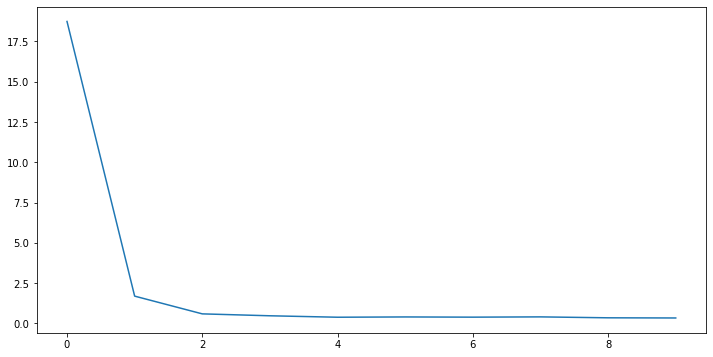

In [154]:
# Convert the training history to a dataframe
history_df = pd.DataFrame(history.history)

# Use Pandas native plot method
history_df['loss'].plot();

In [155]:
# Returning the metrics of this model
print_metrics(model.predict(X_train),y_train)

MAE: 0.455397030590254
RMSE: [0.60709707]
R^2: -0.078369656649379


* There was not enough time to explore this model further, so the Neural Network model was not tested or incorporated into the Ensemble

<a id='9'></a>
## 9. Testing the models

=> [Return to the top](#1) <=

The models are now going to be tested on the test data. This will proceed as follows
* 9.1. Linear Regression Model
* 9.2. ARIMA Model
* 9.3. Ensemble Model

#### 9.1. Linear Regression
* Creating the linear regression model. The linear regression model is built using the linear_regression_model class defined in [Section 3](#3).

In [156]:
# List of the features that produced the best model
best_features = ['hh', 'wdir', 'wspd', 'dpd', 'mwd', 'pres', 'wtmp']

In [157]:
# Using the linear_regression_model class
model_lin_reg_test = linear_regression_model(wave_height_train_clean,best_features,'wvht')

In [158]:
# Summary of the model
model_lin_reg_test.results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   wvht   R-squared (uncentered):                   0.924
Model:                            OLS   Adj. R-squared (uncentered):              0.924
Method:                 Least Squares   F-statistic:                          1.037e+04
Date:                Thu, 10 Mar 2022   Prob (F-statistic):                        0.00
Time:                        11:13:24   Log-Likelihood:                         -1447.5
No. Observations:                5947   AIC:                                      2909.
Df Residuals:                    5940   BIC:                                      2956.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
hh             0.0034      0.001      5.946      0.000       0.002       0.005
wdir          -0.0002   4.26e-05     -3.581      0.000      -0.000   -6.91e-05
wspd           0.1315      0.001     92.661      0.000       0.129       0.134
dpd            0.1474      0.004     39.287      0.000       0.140       0.155
mwd           -0.0001   3.96e-05     -3.327      0.001      -0.000    -5.4e-05
pres          -0.0002   4.34e-05     -4.858      0.000      -0.000      -0.000
wtmp          -0.0188      0.001    -14.426      0.000      -0.021      -0.016
==============================================================================
Omnibus:                      509.675   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2171.165
Skew:                           0.328   Prob(JB):                         0.00
Kurtosis:                       5.887   Cond. No.                         994.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* Applying the model to the test data

In [159]:
model_lin_reg_test.predict(test_df_clean)

MAE: 0.2245583751275099
RMSE: 0.3056071359007128
R-squared: 0.9243767765239845


* Creating a figure of the plot for the presentation

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6402: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  key,


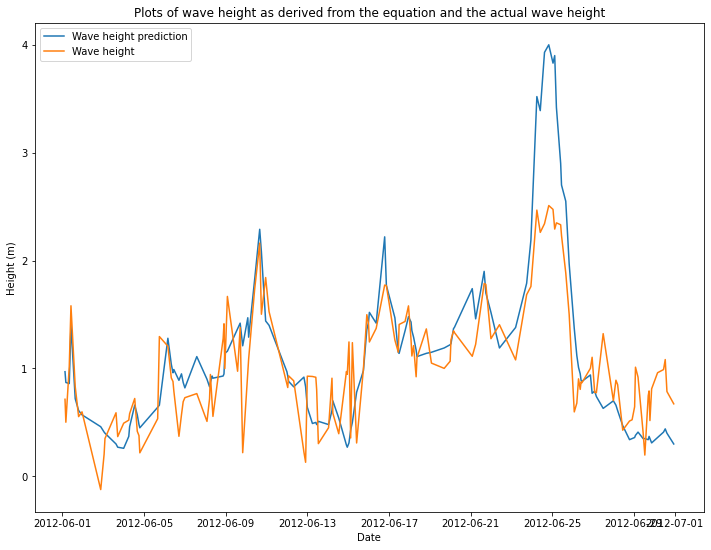

In [160]:
# Making a plot of the data
model_lin_reg_test.plot(date = '2012-06')

# Saving the plot
plt.savefig('wave_height.png')

#### 9.2. ARIMA model
* Testing the ARIMA model will make use of the class defined [Section 4](#4.4).

In [161]:
# Creating the best arima model
model_arima_test = arima_model(ts_wave_height_train[['wvht']],(2,1,0))


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:595: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [162]:
model_arima_test.ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   wvht   No. Observations:                 5953
Model:                 ARIMA(2, 1, 0)   Log Likelihood                5661.151
Date:                Thu, 10 Mar 2022   AIC                         -11316.303
Time:                        11:13:25   BIC                         -11296.228
Sample:                             0   HQIC                        -11309.329
                               - 5953                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0772      0.007     10.846      0.000       0.063       0.091
ar.L2          0.1503      0.008     19.486      0.000       0.135       0.165
sigma2         0.0087   7.26e-05    120.381      0.000       0.009       0.009
===================================================================================
Ljung-Box (L1) (Q):                   0.35   Jarque-Bera (JB):             15477.33
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                             0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

* The testing will make use of the ts_wave_height_test dataset from the test - train split in Section 4.

In [163]:
# Look at the test data frame to be used
ts_wave_height_test.head()

wvht
date                     
2012-10-27 14:00:00  1.60
2012-10-27 15:00:00  1.39
2012-10-27 17:00:00  1.43
2012-10-27 18:00:00  1.35
2012-10-27 19:00:00  1.29

* Creating predictions using the model & assessing accuracy

In [164]:
# Makes predictions using the prediction method
arima_test_preds = model_arima_test.predict(start = 2, end = len(ts_wave_height_test)-1,
                                      use_data = ts_wave_height_test)


In [165]:
# First look at the test prediction dataframe
arima_test_preds.head()

y_pred
0  1.258697
1  1.202724
2  1.227971
3  1.322452
4  1.465481

In [166]:
# Prints the relevant metrics of the predictions
print_metrics(arima_test_preds,ts_wave_height_test.iloc[2:-1])

MAE: 0.08999246844090276
RMSE: [0.12103205]
R^2: 0.9575489764710667


* Creating a figure of the predictions and observations 

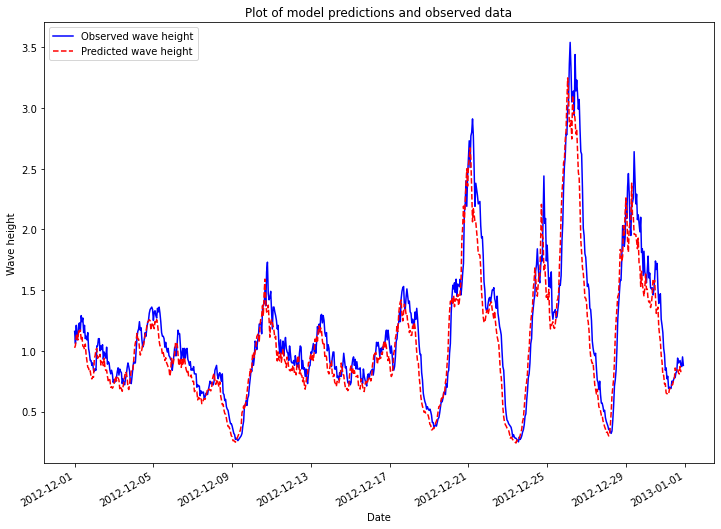

In [167]:
# Using the ARIMA plot function
arima_plot(arima_test_preds,ts_wave_height_test,date = '2012-12')

#### 9.3. Ensemble model

The Ensemble model defined in Section 7 will now be tested. This Ensemble model uses the ARIMA predictions as a feature to be used in Linear Regression.

* First, recalling the predictions on the test data from the ARIMA model defined above

In [168]:
# Adding the test_preds to the en_wave_height_test
en_wave_height_test = en_wave_height_test.drop(en_wave_height_test.index[[0,1,2]]).reset_index()

In [169]:
# Adds a column for the arima predictions to the test data frame
en_wave_height_test[['arima_preds']] = arima_test_preds

In [170]:
# Quick look at the data frame
en_wave_height_test.head()

index                date  wvht   #yy  mm  dd  hh  mins  wdir  wspd  ...  \
0      3 2012-10-27 18:00:00  1.35  2012  10  27  18    50   336   9.2  ...   
1      4 2012-10-27 19:00:00  1.29  2012  10  27  19    50   335   9.8  ...   
2      5 2012-10-27 20:00:00  1.33  2012  10  27  20    50   334   9.7  ...   
3      6 2012-10-27 21:00:00  1.45  2012  10  27  21    50   337  10.2  ...   
4      7 2012-10-27 22:00:00  1.61  2012  10  27  22    50   330  10.8  ...   

    dpd   apd    mwd    pres  atmp  wtmp  dewp   vis  tide  arima_preds  
0  5.56  4.54  352.0  1011.1  18.8  27.2  18.8  99.0  99.0     1.258697  
1  5.56  4.44  345.0  1010.9  18.6  27.2  18.6  99.0  99.0     1.202724  
2  5.56  4.46  343.0  1010.7  18.5  27.2  18.5  99.0  99.0     1.227971  
3  5.56  4.52  347.0  1010.9  18.4  27.1  18.3  99.0  99.0     1.322452  
4  5.56  4.71  343.0  1011.1  17.7  27.1  17.6  99.0  99.0     1.465481  

[5 rows x 21 columns]

In [171]:
en_wave_height_test.tail()

index                date  wvht   #yy  mm  dd  hh  mins  wdir  wspd  \
1481   1484 2012-12-31 18:00:00  0.92  2012  12  31  18    50   179   4.4   
1482   1485 2012-12-31 19:00:00  0.88  2012  12  31  19    50   167   2.5   
1483   1486 2012-12-31 20:00:00  0.87  2012  12  31  20    50   163   2.9   
1484   1487 2012-12-31 21:00:00  0.95  2012  12  31  21    50   160   2.6   
1485   1488 2012-12-31 22:00:00  0.88  2012  12  31  22    50   141   3.6   

      ...   dpd   apd    mwd    pres  atmp  wtmp  dewp   vis  tide  \
1481  ...  5.26  4.45  100.0  1022.2  19.8  22.2  13.1  99.0  99.0   
1482  ...  5.00  4.49  108.0  1021.4  19.9  22.3  13.6  99.0  99.0   
1483  ...  5.26  4.50  107.0  1020.8  20.2  22.4  14.4  99.0  99.0   
1484  ...  5.56  4.75  100.0  1020.6  20.4  22.3  15.1  99.0  99.0   
1485  ...  5.56  4.59  105.0  1020.1  20.7  22.3  15.4  99.0  99.0   

      arima_preds  
1481     0.852051  
1482     0.819770  
1483     0.808662  
1484     0.870939  
1485     0.823721  

[5 rows x 21 columns]

* Uses the ARIMA predictions above as a feature in the linear regression model

In [172]:
# Creates a list of column names to be used as features
ensemble_feats = best_features + ['arima_preds']

ensemble_model = linear_regression_model(en_wave_height_train,ensemble_feats,'wvht')

# Creates the ensemble model
lin_reg = sm.OLS(en_wave_height_train['wvht'], en_wave_height_train[ensemble_feats])
ensemble_model2 = lin_reg.fit()

In [173]:
# Creates the predictions
predictions = ensemble_model.predict(en_wave_height_test)

MAE: 0.06412623248321699
RMSE: 0.08296746628308425
R-squared: 0.9937613576467516


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


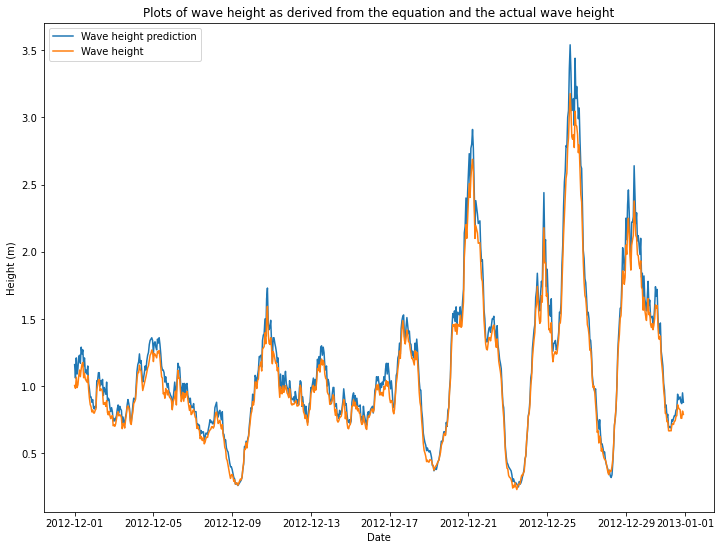

In [174]:
# Creates a plot of the predictions and observations
ensemble_model.plot(date = '2012-12')

In [175]:
# Prints the parameters of the ensemble model
print('ARIMA model parameters:\n============\n',
      model_arima_test.ar.params,'\n============')
print('\nEnsemble model parameters:\n============\n',
      ensemble_model.results.params,'\n============')

ARIMA model parameters:
 ar.L1     0.077241
ar.L2     0.150340
sigma2    0.008737
dtype: float64 

Ensemble model parameters:
 hh            -0.000248
wdir          -0.000051
wspd           0.016986
dpd            0.008562
mwd            0.000006
pres          -0.000049
wtmp          -0.000401
arima_preds    0.912617
dtype: float64 


* Here is a demonstration of the model in action. Originally, the plan was to show either an animation of the numerical data being filled in, else a streamlit application so that the audience could do it themselves. Since streamlit was not compatible with the device being used, and the animation was of poor quality, neither of these were completed. Had more time been available, it might have been possible to demostrate this

In [176]:
def wave_height_predict():
    '''
    Function for producing a wave height prediction, using the parameters from the ensemlbe 
    model defined above
    ----------
    Inputs:
    a : hour of the day
    b : wind direction 
    c : wind speed
    d : dominant wave period
    e : wave direction
    f : sea level pressure
    g : water temperature
    h : last recorded wave height
    i : second to last wave height
    ---------
    print : wave height prediction
    '''
    try:
        a = float(input('Enter the hour:'))
        # Raising an error if the hour is out of range 
        assert a <= 24 and a >= 0
        b = float(input('Enter the wind direction:'))
        # Raising an error if the wind direction is out of range 
        assert b < 360 and b >= 0
        c = float(input('Enter the wind speed:'))
        d = float(input('Enter the dominant wave period:'))
        e = float(input('Enter the wave direction :'))
        # Raising an error if the wave direction is out of range 
        assert e < 360 and e >= 0
        f = float(input('Enter the sea level pressure:'))
        g = float(input('Enter the water temperature:'))
        h = float(input('Enter the last recorded wave height:'))
        i = float(input('Enter the second to last recorded wave height:'))
    except:
        print('The last value you entered was out of range')
        
    # Creating an ARIMA prediction using the ARIMA parameters    
    j = (0.77241 * h) + (0.150340 * i) + (0.008737*np.random.rand())
    
    # Creating a final answer for the prediction
    answer = (a * -0.000248) + (b*-0.000051) + (c*0.016986) + (d*0.008562) + (e*0.000006)
    + (f*-0.000049) + (g*-0.000401) + (j*0.912617)
    
    # Creates a string containing the wave height prediction
    answer_string = 'Wave Height Prediction:' + str(round(answer,2)) + 'm'
    
    # Prints the string
    print('-'*len(answer_string),'\n',answer_string,'\n','-'*len(answer_string))

In [177]:
wave_height_predict()

Enter the hour: 12
Enter the wind direction: 230
Enter the wind speed: 4
Enter the dominant wave period: 5
Enter the wave direction : 10
Enter the sea level pressure: 5
Enter the water temperature: 4
Enter the last recorded wave height: 3.4
Enter the second to last recorded wave height: 3.5


--------------------------- 
 Wave Height Prediction:0.1m 
 ---------------------------
